To see the effect of weight initialization, we'll use a specific data set for all our experiments

In [75]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.display import Image
import matplotlib.pyplot as plt


from pandas.core.common import flatten
import copy
import numpy as np

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

import glob
from tqdm import tqdm


from train import train, validation

### Load dataset

In [2]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)



### Define the model

We define the model with an option to choose an activation function. The kind of activations can be chosen accordingly for our experiments. I'll be going through the model with tanh activations. Please feel free to fork the notebook and visualize what happens with other activation functions.

In [3]:
class Network(nn.Module):
    def __init__(self,act_func):
        super().__init__()
        if act_func=='sigmoid':
            self.fc1 = nn.Linear(784, 1024)
            self.act1 = nn.Sigmoid()
            self.fc2 = nn.Linear(1024,512)
            self.act2 = nn.Sigmoid()  #need to repeat these to access in forward hooks by name
            self.fc3 = nn.Linear(512, 256)
            self.act3 = nn.Sigmoid()
            self.fc4 = nn.Linear(256, 128)
            self.act4 = nn.Sigmoid()
            self.fc5 = nn.Linear(128, 10)
            self.softmax = nn.LogSoftmax(dim=1)
            
        if act_func=='tanh':
            self.fc1 = nn.Linear(784, 1024)
            self.act1 = nn.Tanh()
            self.fc2 = nn.Linear(1024,512)
            self.act2 = nn.Tanh()  #need to repeat these to access in forward hooks by name
            self.fc3 = nn.Linear(512, 256)
            self.act3 = nn.Tanh()
            self.fc4 = nn.Linear(256, 128)
            self.act4 = nn.Tanh()
            self.fc5 = nn.Linear(128, 10)
            self.softmax = nn.Softmax(dim=1)
        
        if act_func=='relu':
            self.fc1 = nn.Linear(784, 1024)
            self.act1 = nn.ReLU()
            self.fc2 = nn.Linear(1024,512)
            self.act2 = nn.ReLU()  #need to repeat these to access in forward hooks by name
            self.fc3 = nn.Linear(512, 256)
            self.act3 = nn.ReLU()
            self.fc4 = nn.Linear(256, 128)
            self.act4 = nn.ReLU()
            self.fc5 = nn.Linear(128, 10)
            self.softmax = nn.Softmax(dim=1)
    
    def forward(self,x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        x = self.act3(x)
        x = self.fc4(x)
        x = self.act4(x)
        x = self.fc5(x)
        x = self.softmax(x) 
        
        return x
 

### Define Hooks
We'll define a function to get our activations from the hidden layers. It returns a dictionary of {layer_name : activation}

In [4]:
def forward_hooks(model):
    activations = {}
    def get_activation(name):
        def activation_hook(inst, inp, out):
            """
            Run activation hook.
            Parameters
            ----------
            inst : torch.nn.Module
                The layer we want to attach the hook to.
            inp : tuple of torch.Tensor
                The input to the `forward` method.
            out : torch.Tensor
                The output of the `forward` method.
            """
            activations[name] = out.data
        return activation_hook
    
    
    for name, layer in model.named_modules():
        layer.register_forward_hook(get_activation(name))
    return activations
    


### Plot Activations
We'll plot both the hidden output and corresponding  activations.

In [5]:
def plot_activations(activations):
    num_plots = len(list(activations.keys()))-1
    figure, ax = plt.subplots(nrows=num_plots, ncols=1, figsize=(12, 20))
    i = 0
    for name, activation in activations.items():
        if name=='':
            break
        if i%2==0:
            color = 'blue'
            ax.ravel()[i].hist(activation.numpy()[0], bins=55, color=color)
            #ax.ravel()[i].set_axis_off()
            ax.ravel()[i].set_title(name)
            i+=1
        else:
            color = 'orange'
            set_ticks = [-1.5, -1,-0.5, 0, 0.5,1, 1.5]
            ax.ravel()[i].hist(activation.numpy()[0], bins=55, color=color)
            #ax.ravel()[i].set_axis_off()
            ax.ravel()[i].set_title(name)
            ax.ravel()[i].set_xticks(set_ticks)
            i+=1
        
        
    plt.tight_layout()
    plt.show()    

### Define all initializing strategies

### Training Loop
train() has been written in an external file

In [7]:
def training(model):
    # train the model
    loss_fn = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr = 0.001)
    num_epochs = 2
    losses = train(num_epochs, trainloader, model, optimizer, 
                      loss_fn, use_cuda=False)
    valid_loss = validation(testloader, model, loss_fn, use_cuda=False)
    return losses

    

In [8]:
activation= 'tanh' #choose relu, sigmoid or tanh

## 1. Constant weights
First, we'll try initialization with constant weights - 0 or 1

![constant](imgs/0_init.jpg)


In [39]:
#init weights to w, b
def weight_init_constant(model, w, b):
    for name, value in model.named_parameters():
        if name.split('.')[1]=='weight':
            torch.nn.init.constant_(value, w)
        else:
            torch.nn.init.constant_(value, b)
    return model

In [9]:
model_zeros = Network(activation)
model_ones = Network(activation)

In [10]:
model_zeros = weight_init_constant(model_zeros, 0,0)
model_ones = weight_init_constant(model_ones, 1,0)

### 1.1 Check out activations of all hidden layers

In [11]:
activations_zeros = forward_hooks(model_zeros)
out = model_zeros(next(iter(trainloader))[0].reshape(64,-1))

activations_ones = forward_hooks(model_ones)
out = model_ones(next(iter(trainloader))[0].reshape(64,-1))

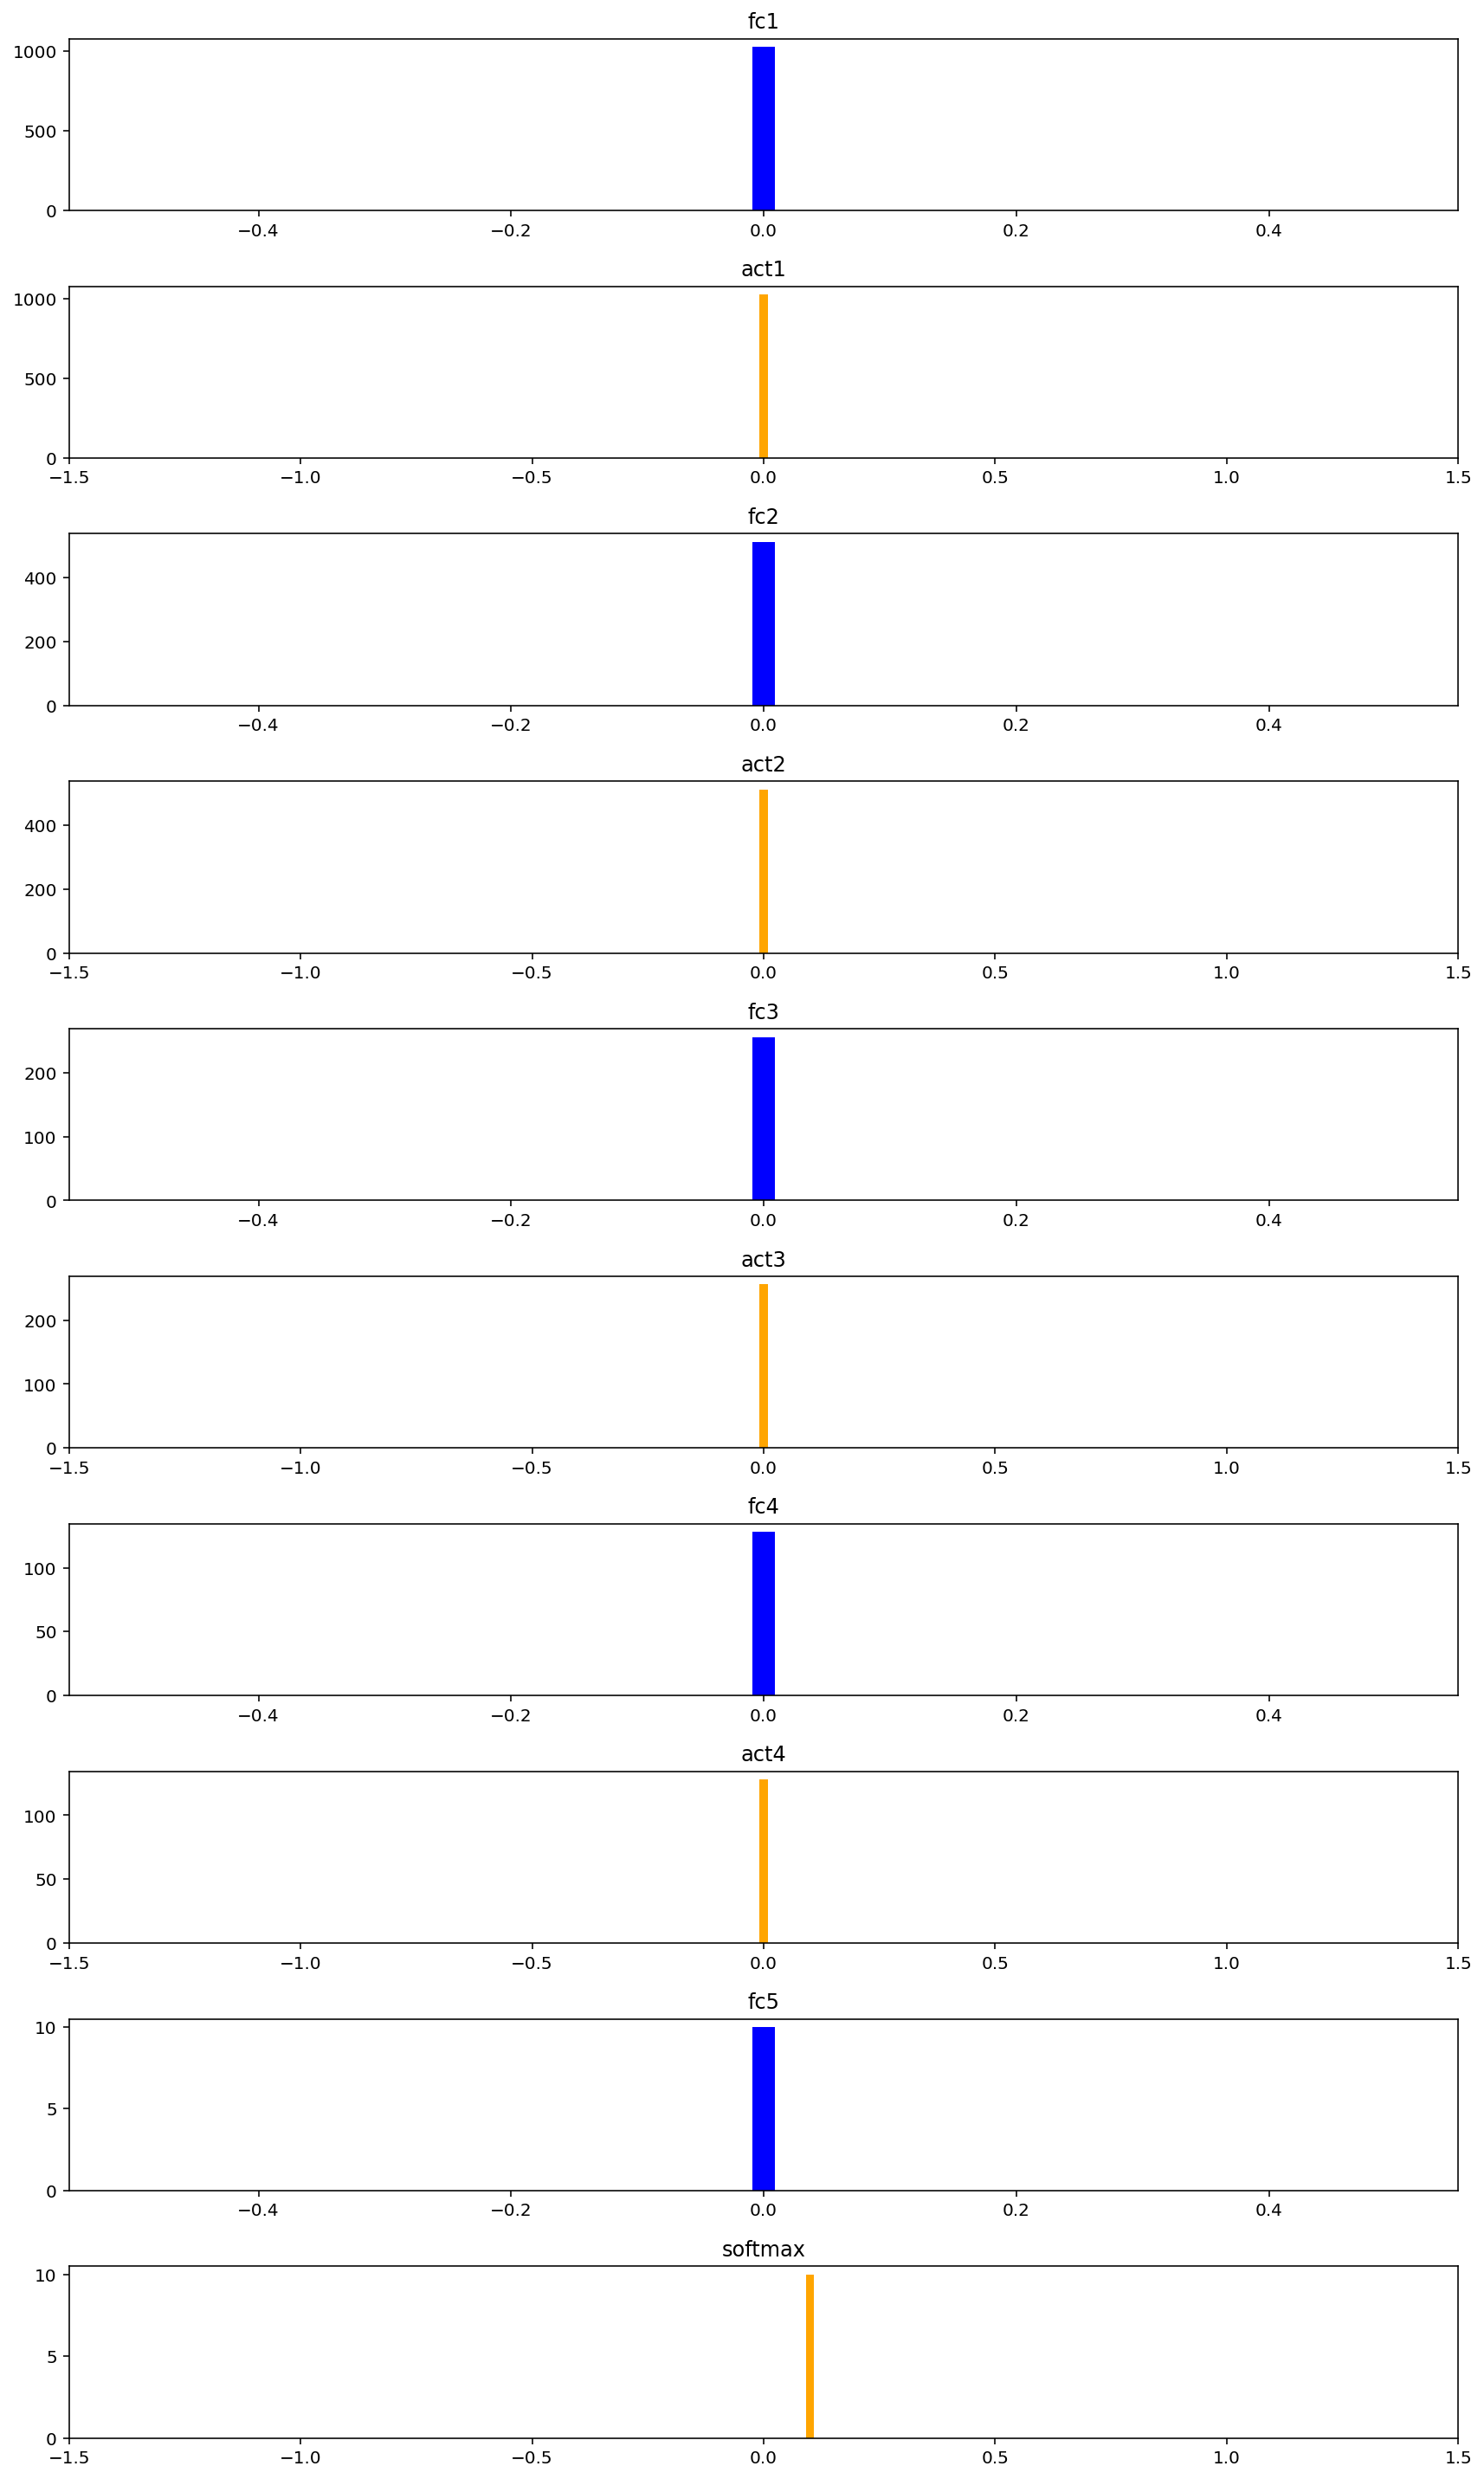

In [12]:
plot_activations(activations_zeros)

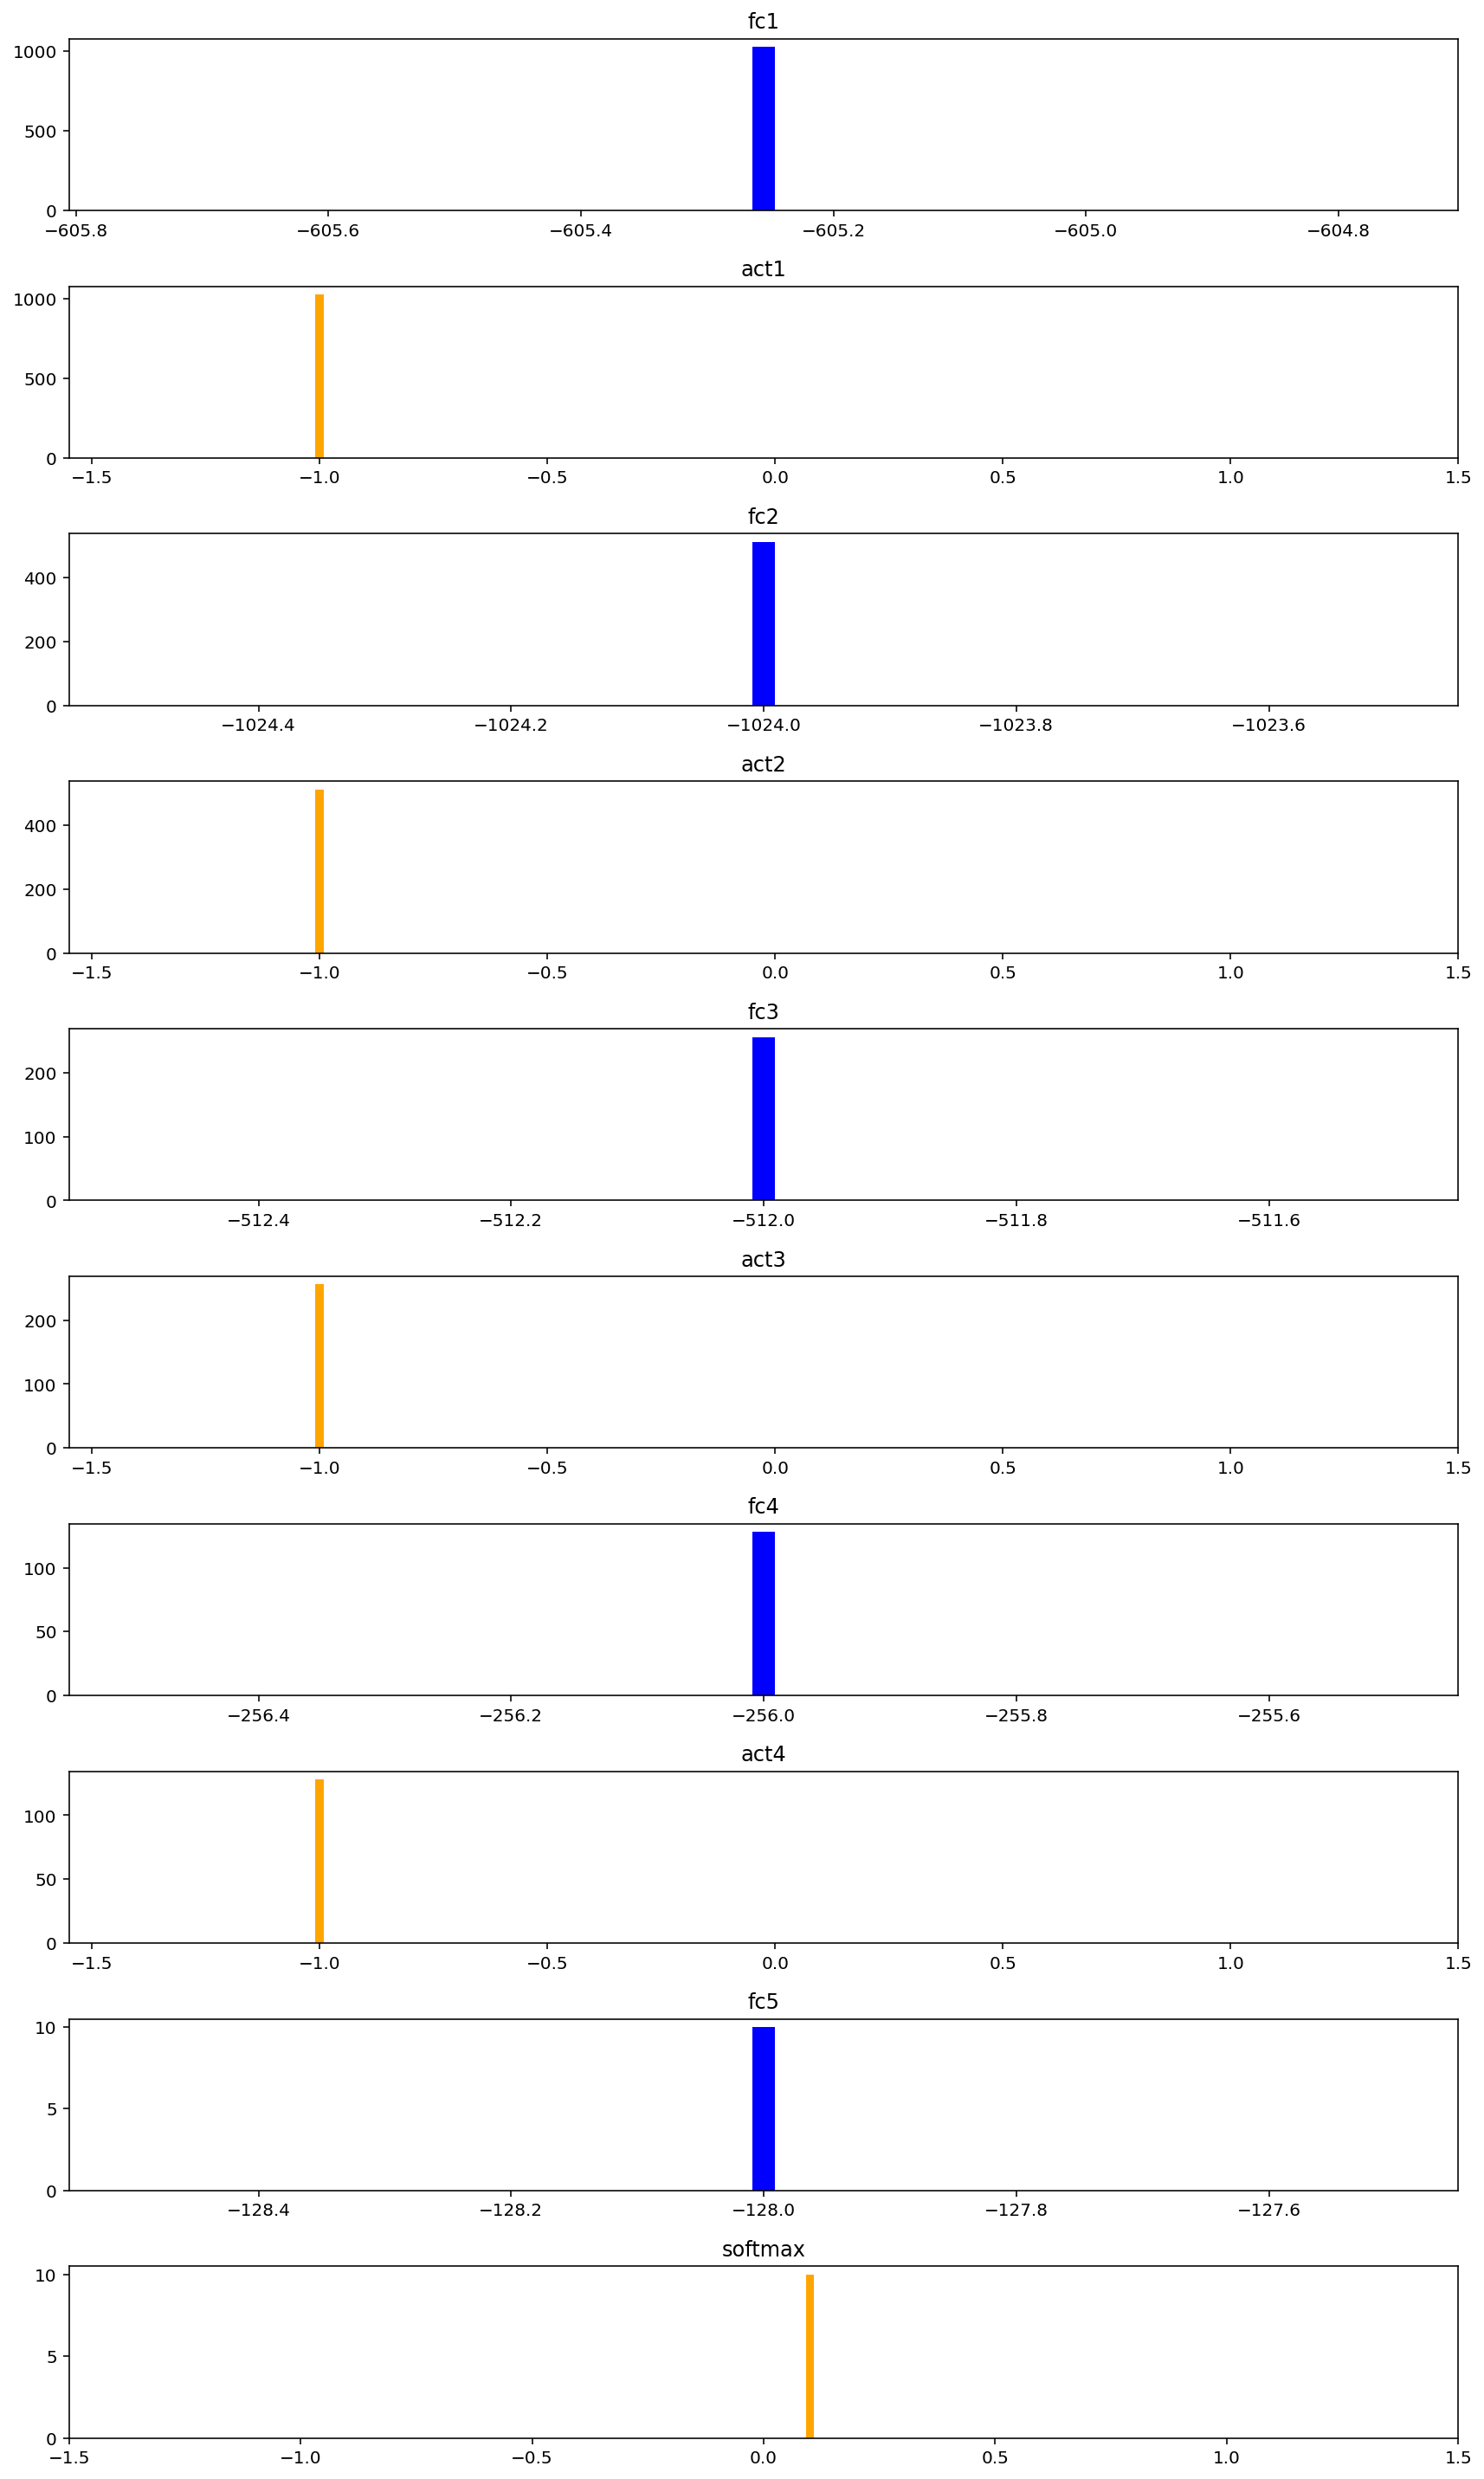

In [13]:
plot_activations(activations_ones)

There is no variance in the activations of the layers. Hence, there will be no learning as we see in the next section

### 1.2 Train loss and valid accuracy

In [14]:
#1. zeros
losses_zeros = training(model_zeros)

Epoch 1 losses : -0.09998132218557139
Epoch 2 losses : -0.0999811391538775

Test Accuracy: 10% (1000/10000)
Valid Loss:  -0.09999968377268235


In [15]:
#2. ones
losses_ones = training(model_ones)

Epoch 1 losses : -0.11673009937712506
Epoch 2 losses : -0.1179630996595853

Test Accuracy: 11% (1172/10000)
Valid Loss:  -0.11722971443798698


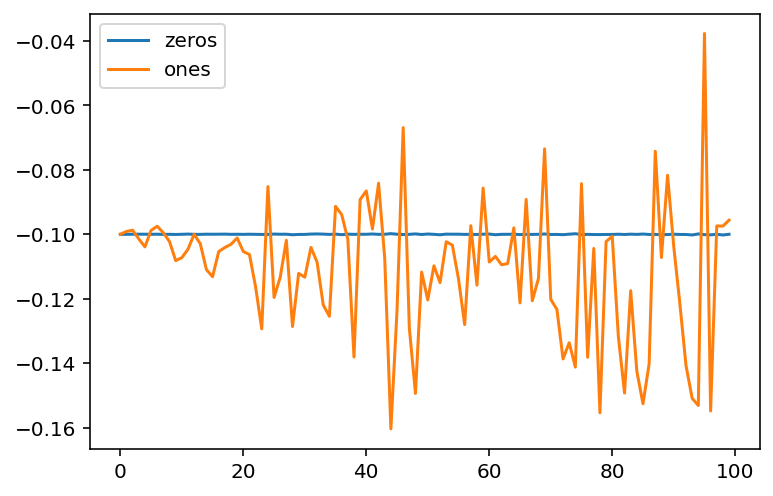

In [16]:
plt.plot(losses_zeros[:100], label='zeros')
plt.plot(losses_ones[:100], label = 'ones')
_=plt.legend()

> The model doesn't learn. The loss remains 0 for 0 initialisation and is very noisy for 1 init.

### 2. Uniform dist (small values)
Here we initialize the weight from a uniform distribution (-0.01,0.01)

We'll notice as we go deeper in the network the values become very small

<img src="imgs/small_init.jpg" width="500" height="300" align="center"/>

In [52]:
# takes in a module and applies the specified weight initialization
def weights_init_uniform_center(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # apply a uniform distribution to the weights and a bias=0
        m.weight.data.uniform_(-0.01, 0.01)
        m.bias.data.fill_(0)
        

In [53]:
# create a new model with these weights
model_uniform = Network(activation)
model_uniform.apply(weights_init_uniform_center)

Network(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (act1): Tanh()
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (act2): Tanh()
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (act3): Tanh()
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (act4): Tanh()
  (fc5): Linear(in_features=128, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

In [59]:
activations_uniform_center = forward_hooks(model_uniform)
out = model_uniform(next(iter(trainloader))[0].reshape(64,-1))

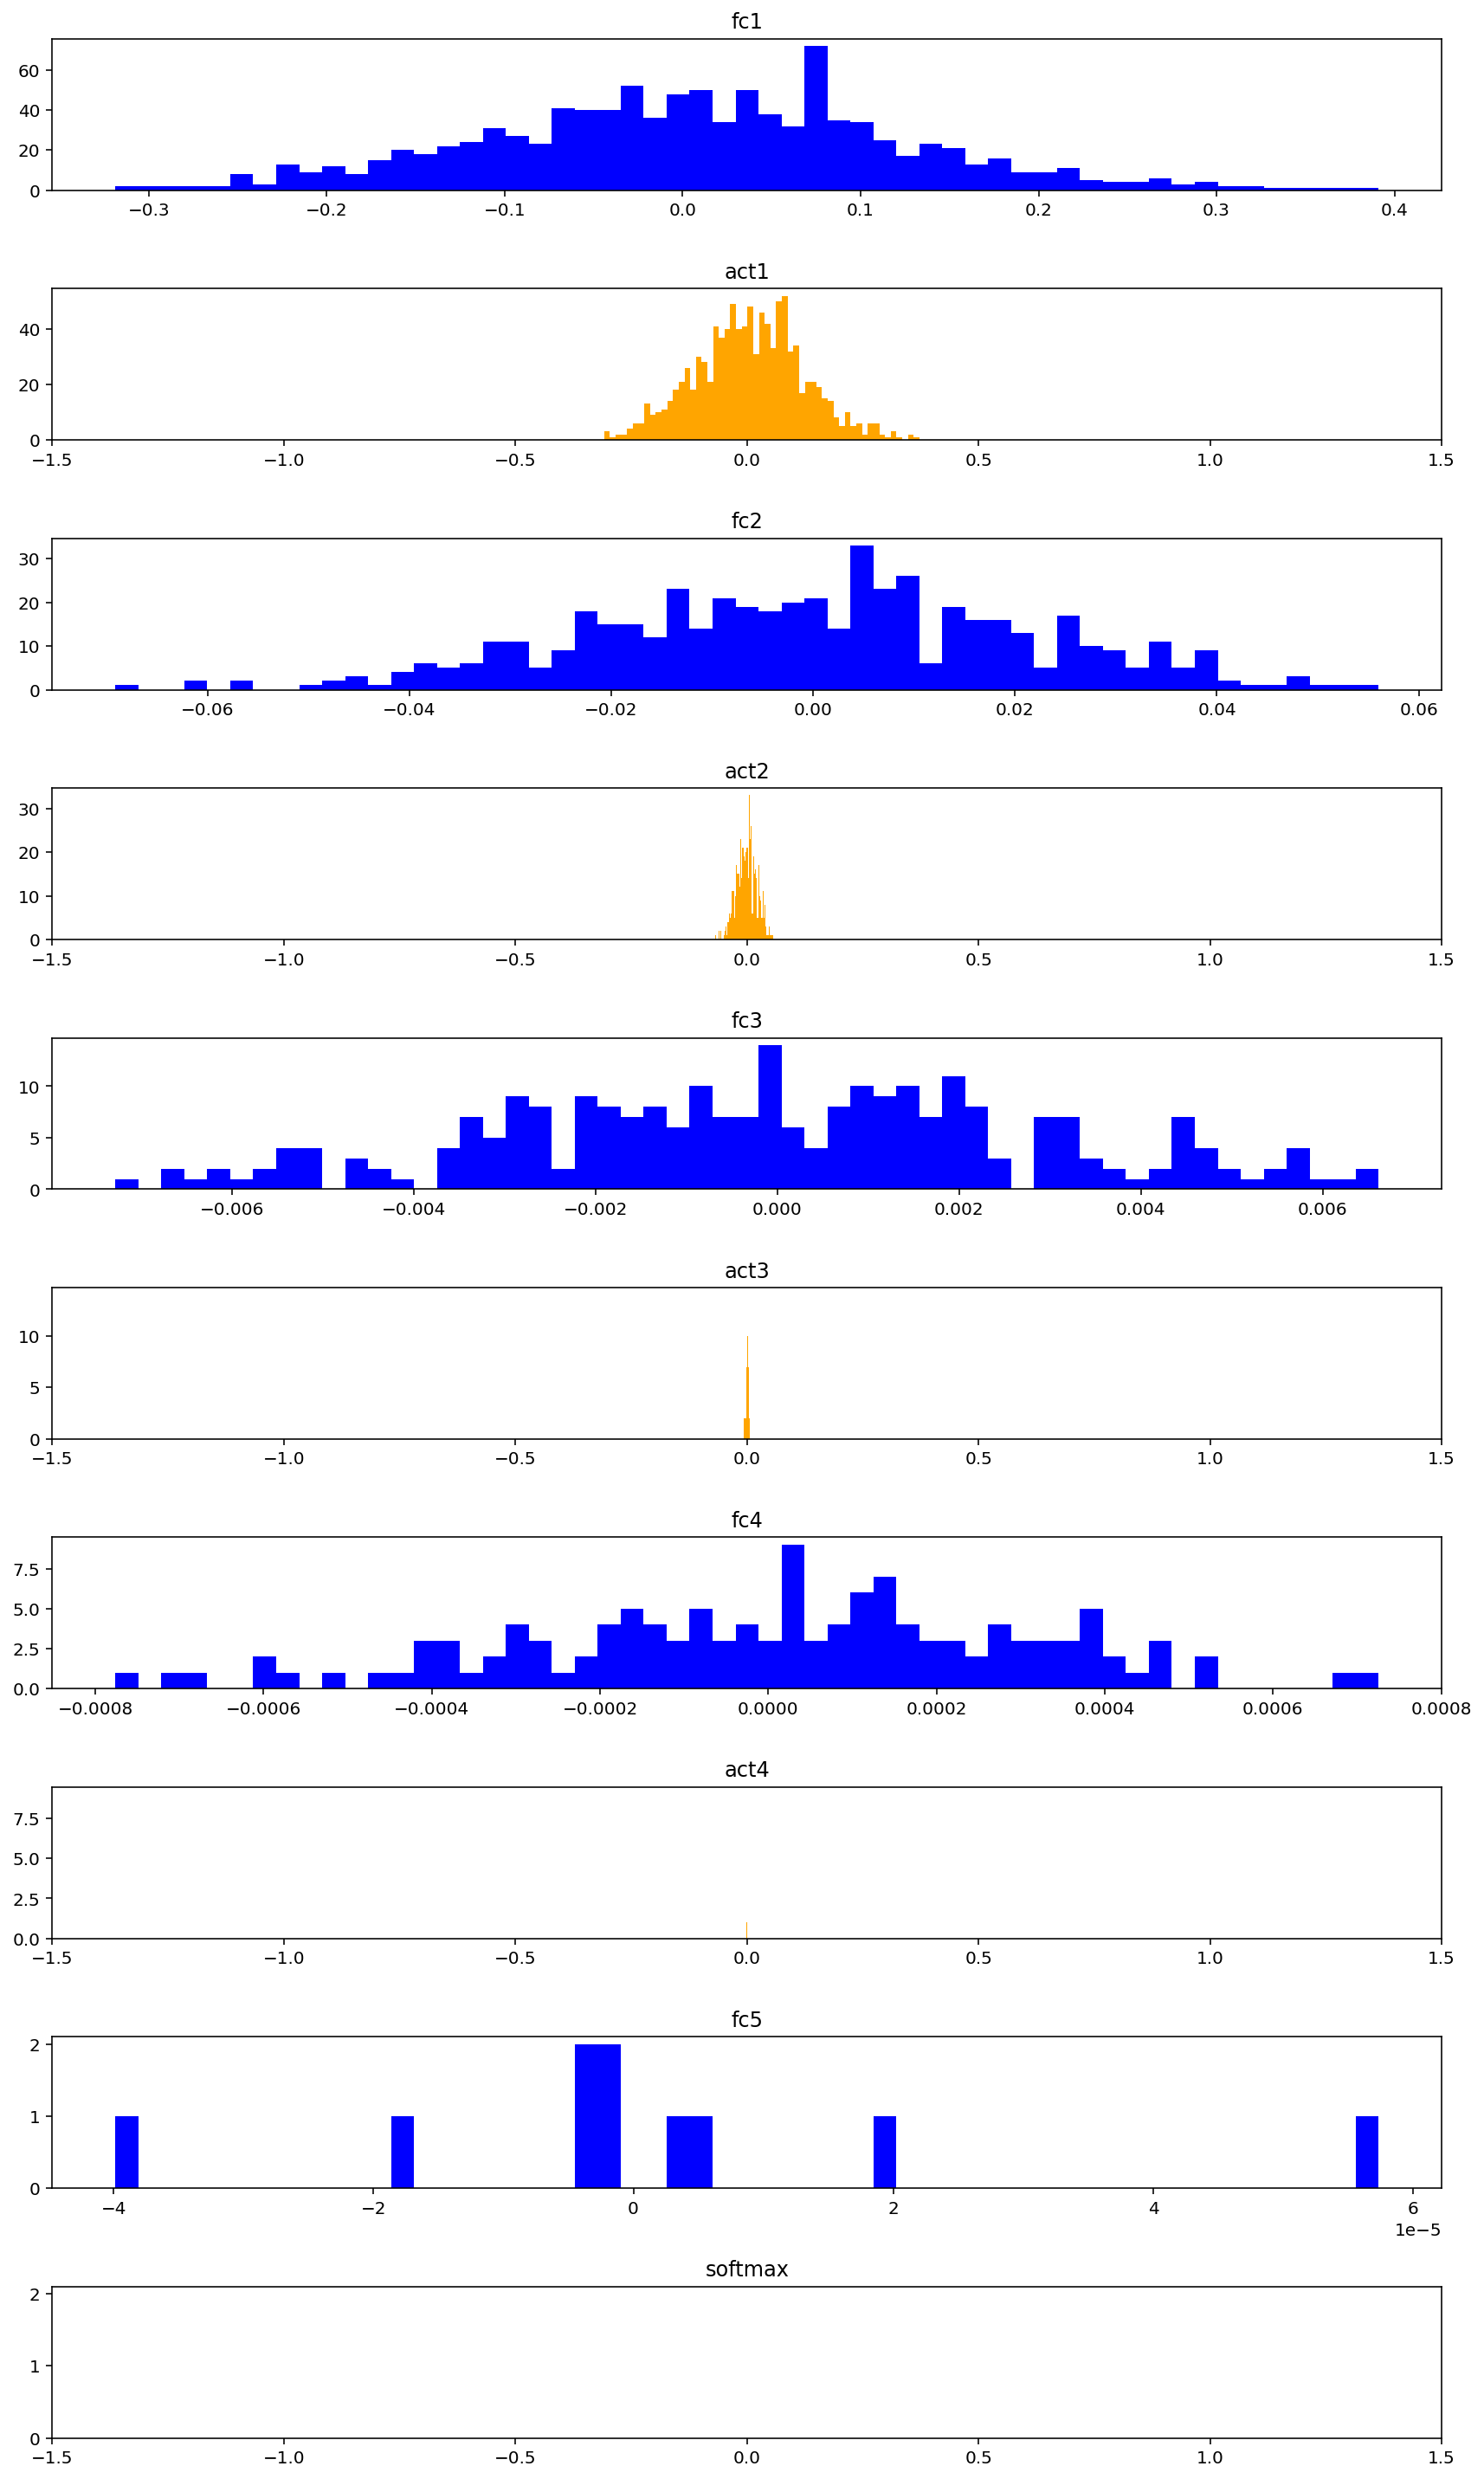

In [55]:
plot_activations(activations_uniform_center)

> We can see that the activations become very close to zero as we reach fc4

In [56]:
losses_uniform = training(model_uniform)

Epoch 1 losses : -0.28467523163633307
Epoch 2 losses : -0.36521982779698603

Test Accuracy: 37% (3743/10000)
Valid Loss:  -0.3748971443077562


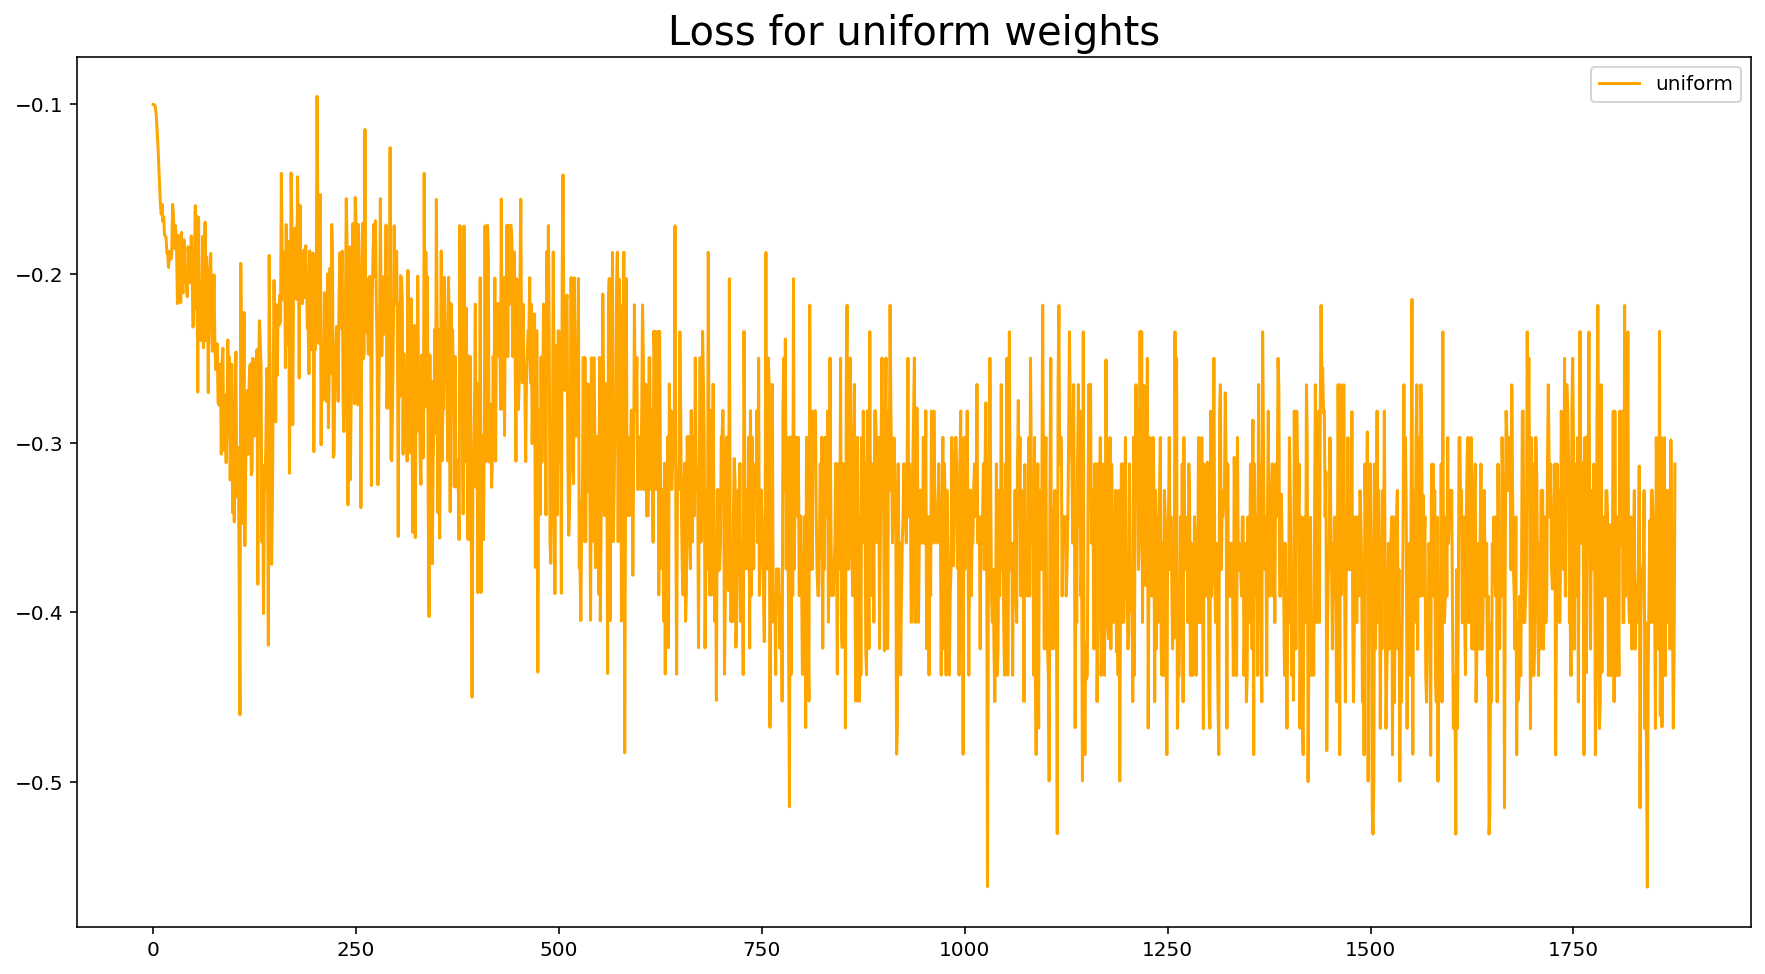

In [57]:
plt.figure(figsize=(15,8))
plt.plot(losses_uniform, label='uniform', color = 'orange')
_ = plt.legend()
_ = plt.title('Loss for uniform weights', fontsize=20)



> The model performs much better than the 0 or 1 init as it reaches an accuracy of 46%. But after some time the loss stops decreasing. 

### 3. Uniform dist (Large values)
Here we initialize the weight from a uniform distribution (-0.8,0.8)

Initializing the network with large values makes the neuron saturated and leads to vanishing gradients

<img src="imgs/large_init.jpg" width="500" height="300" align="center"/>

In [69]:
# takes in a module and applies the specified weight initialization
def weights_init_uniform_center(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # apply a uniform distribution to the weights and a bias=0
        m.weight.data.uniform_(-0.8, 0.8)
        m.bias.data.fill_(0)
        

In [70]:
# create a new model with these weights
model_uniform = Network(activation)
model_uniform.apply(weights_init_uniform_center)

Network(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (act1): Tanh()
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (act2): Tanh()
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (act3): Tanh()
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (act4): Tanh()
  (fc5): Linear(in_features=128, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

In [71]:
activations_uniform_center = forward_hooks(model_uniform)
out = model_uniform(next(iter(trainloader))[0].reshape(64,-1))

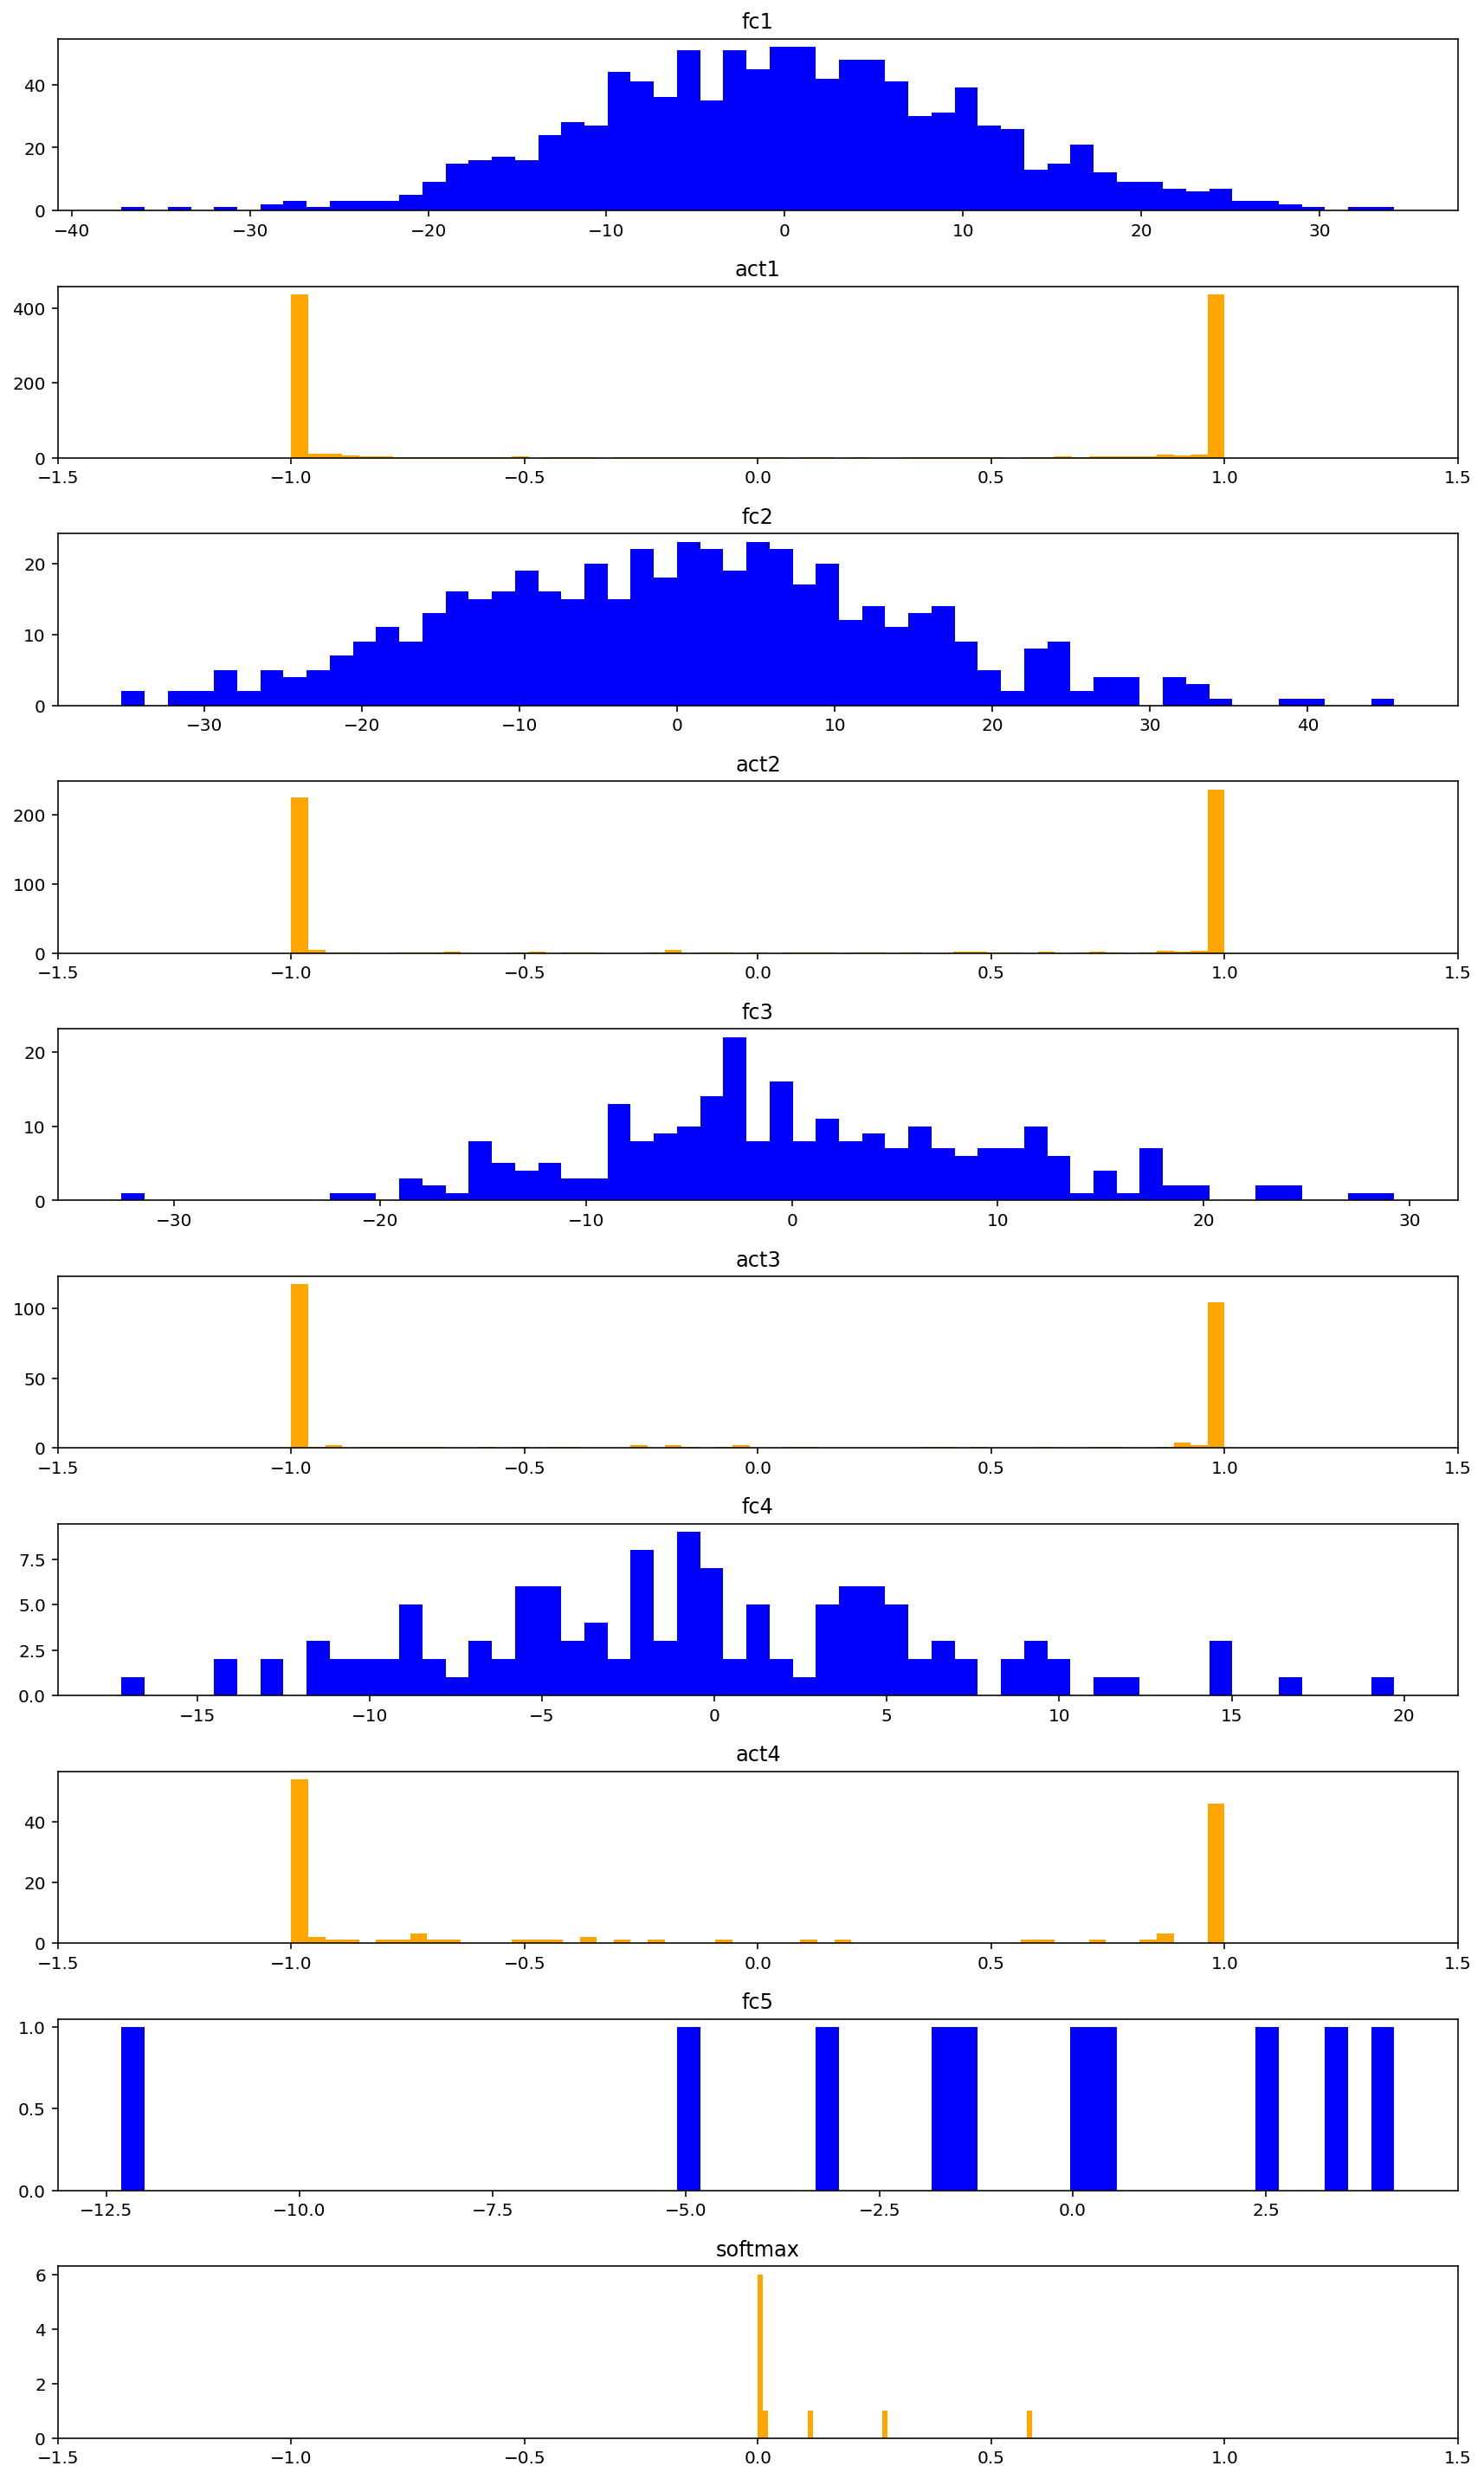

In [72]:
plot_activations(activations_uniform_center)

In [73]:
losses_uniform = training(model_uniform)

Epoch 1 losses : -0.5743068665710844
Epoch 2 losses : -0.6549173488355149

Test Accuracy: 66% (6626/10000)
Valid Loss:  -0.6578237148606856


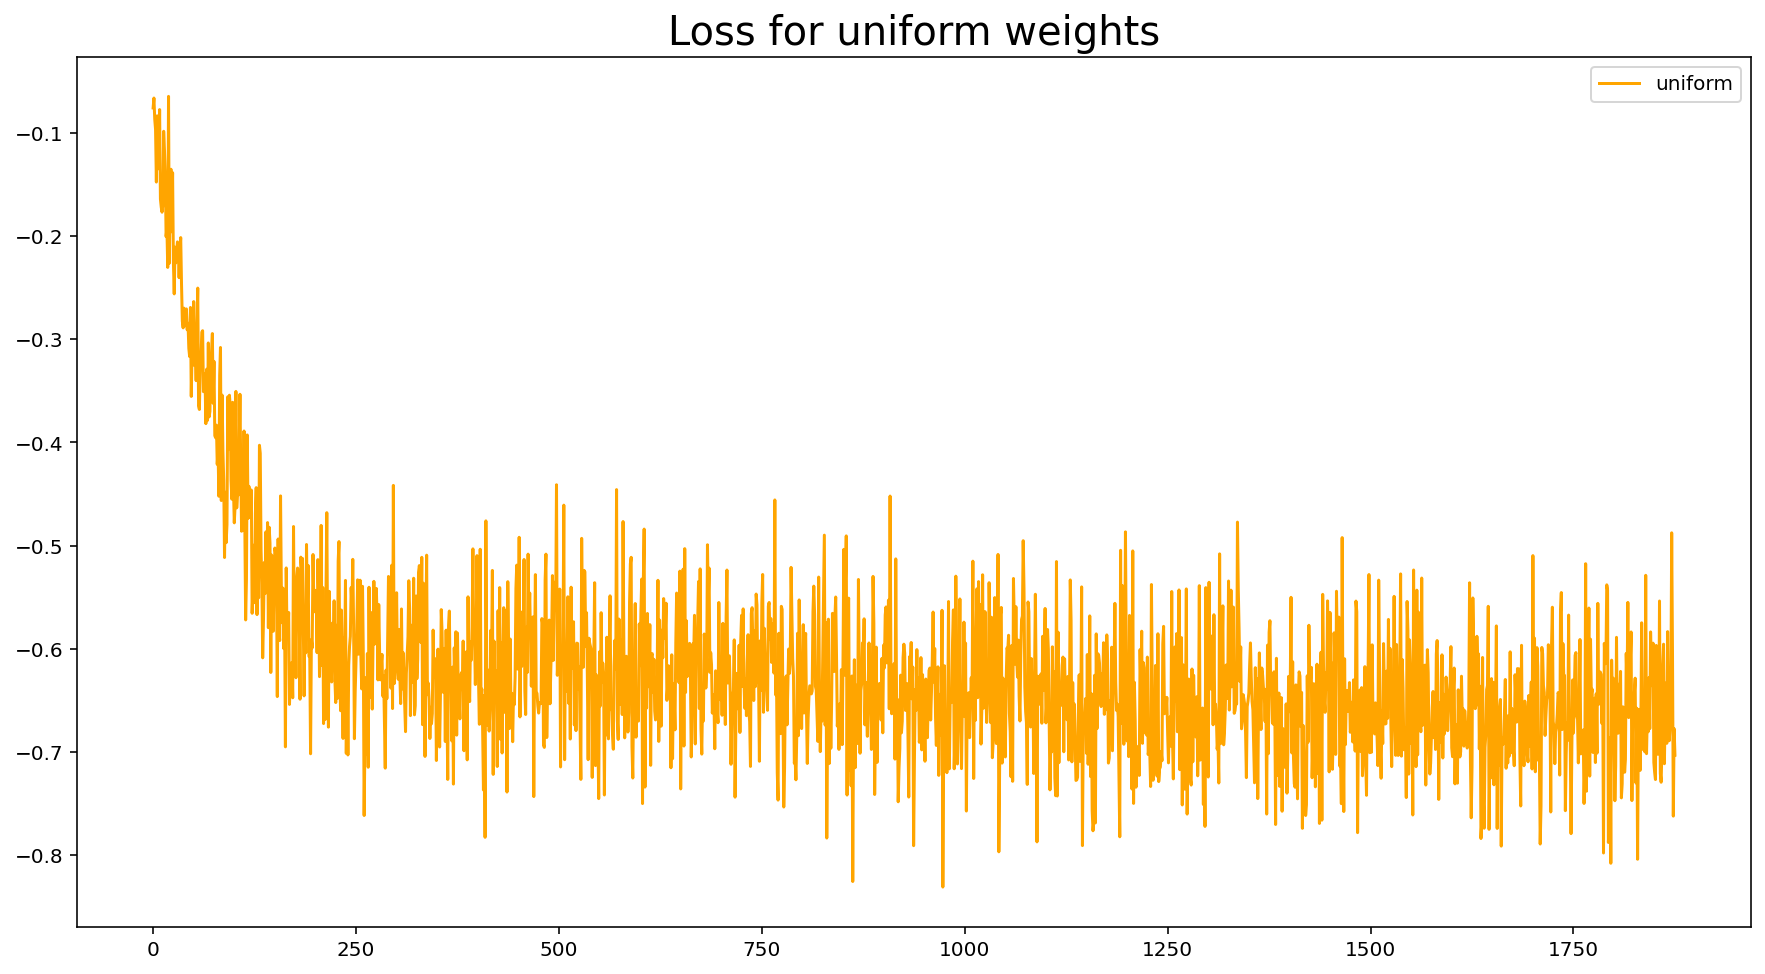

In [74]:
plt.figure(figsize=(15,8))
plt.plot(losses_uniform, label='uniform', color = 'orange')
_ = plt.legend()
_ = plt.title('Loss for uniform weights', fontsize=20)




> We see that the loss reduces faster than the small init values. But again it saturates and stops learning after 750 steps

### 4. Set near zero and General Rule
We set the weights according to the rule **uniform(-1/(hidden_size), 1/(hidden_size))**

These notes are for when we draw weights from a N(0,1) but the principles are the sames

<img src="imgs/xa_1.jpg" width="400" height="500" align="center"/> <img src="imgs/xa_2.jpg" width="350" height="500" align="center"/>

<img src="imgs/xa_3.jpg" width="350" height="500" align="center"/> <img src="imgs/xa_4.jpg" width="350" height="500" align="center"/>


In [81]:
def weights_init_uniform_rule(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        #m.bias.data.fill_(0)
        m.bias.data.uniform_(-y, y)

In [22]:
# create a new model with these weights
model_uniform_rule = Network(activation)
model_uniform_rule.apply(weights_init_uniform_rule)

Network(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (act1): Tanh()
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (act2): Tanh()
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (act3): Tanh()
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (act4): Tanh()
  (fc5): Linear(in_features=128, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

In [23]:
activations_uniform_rule = forward_hooks(model_uniform_rule)
out = model_uniform_rule(next(iter(trainloader))[0].reshape(64,-1))

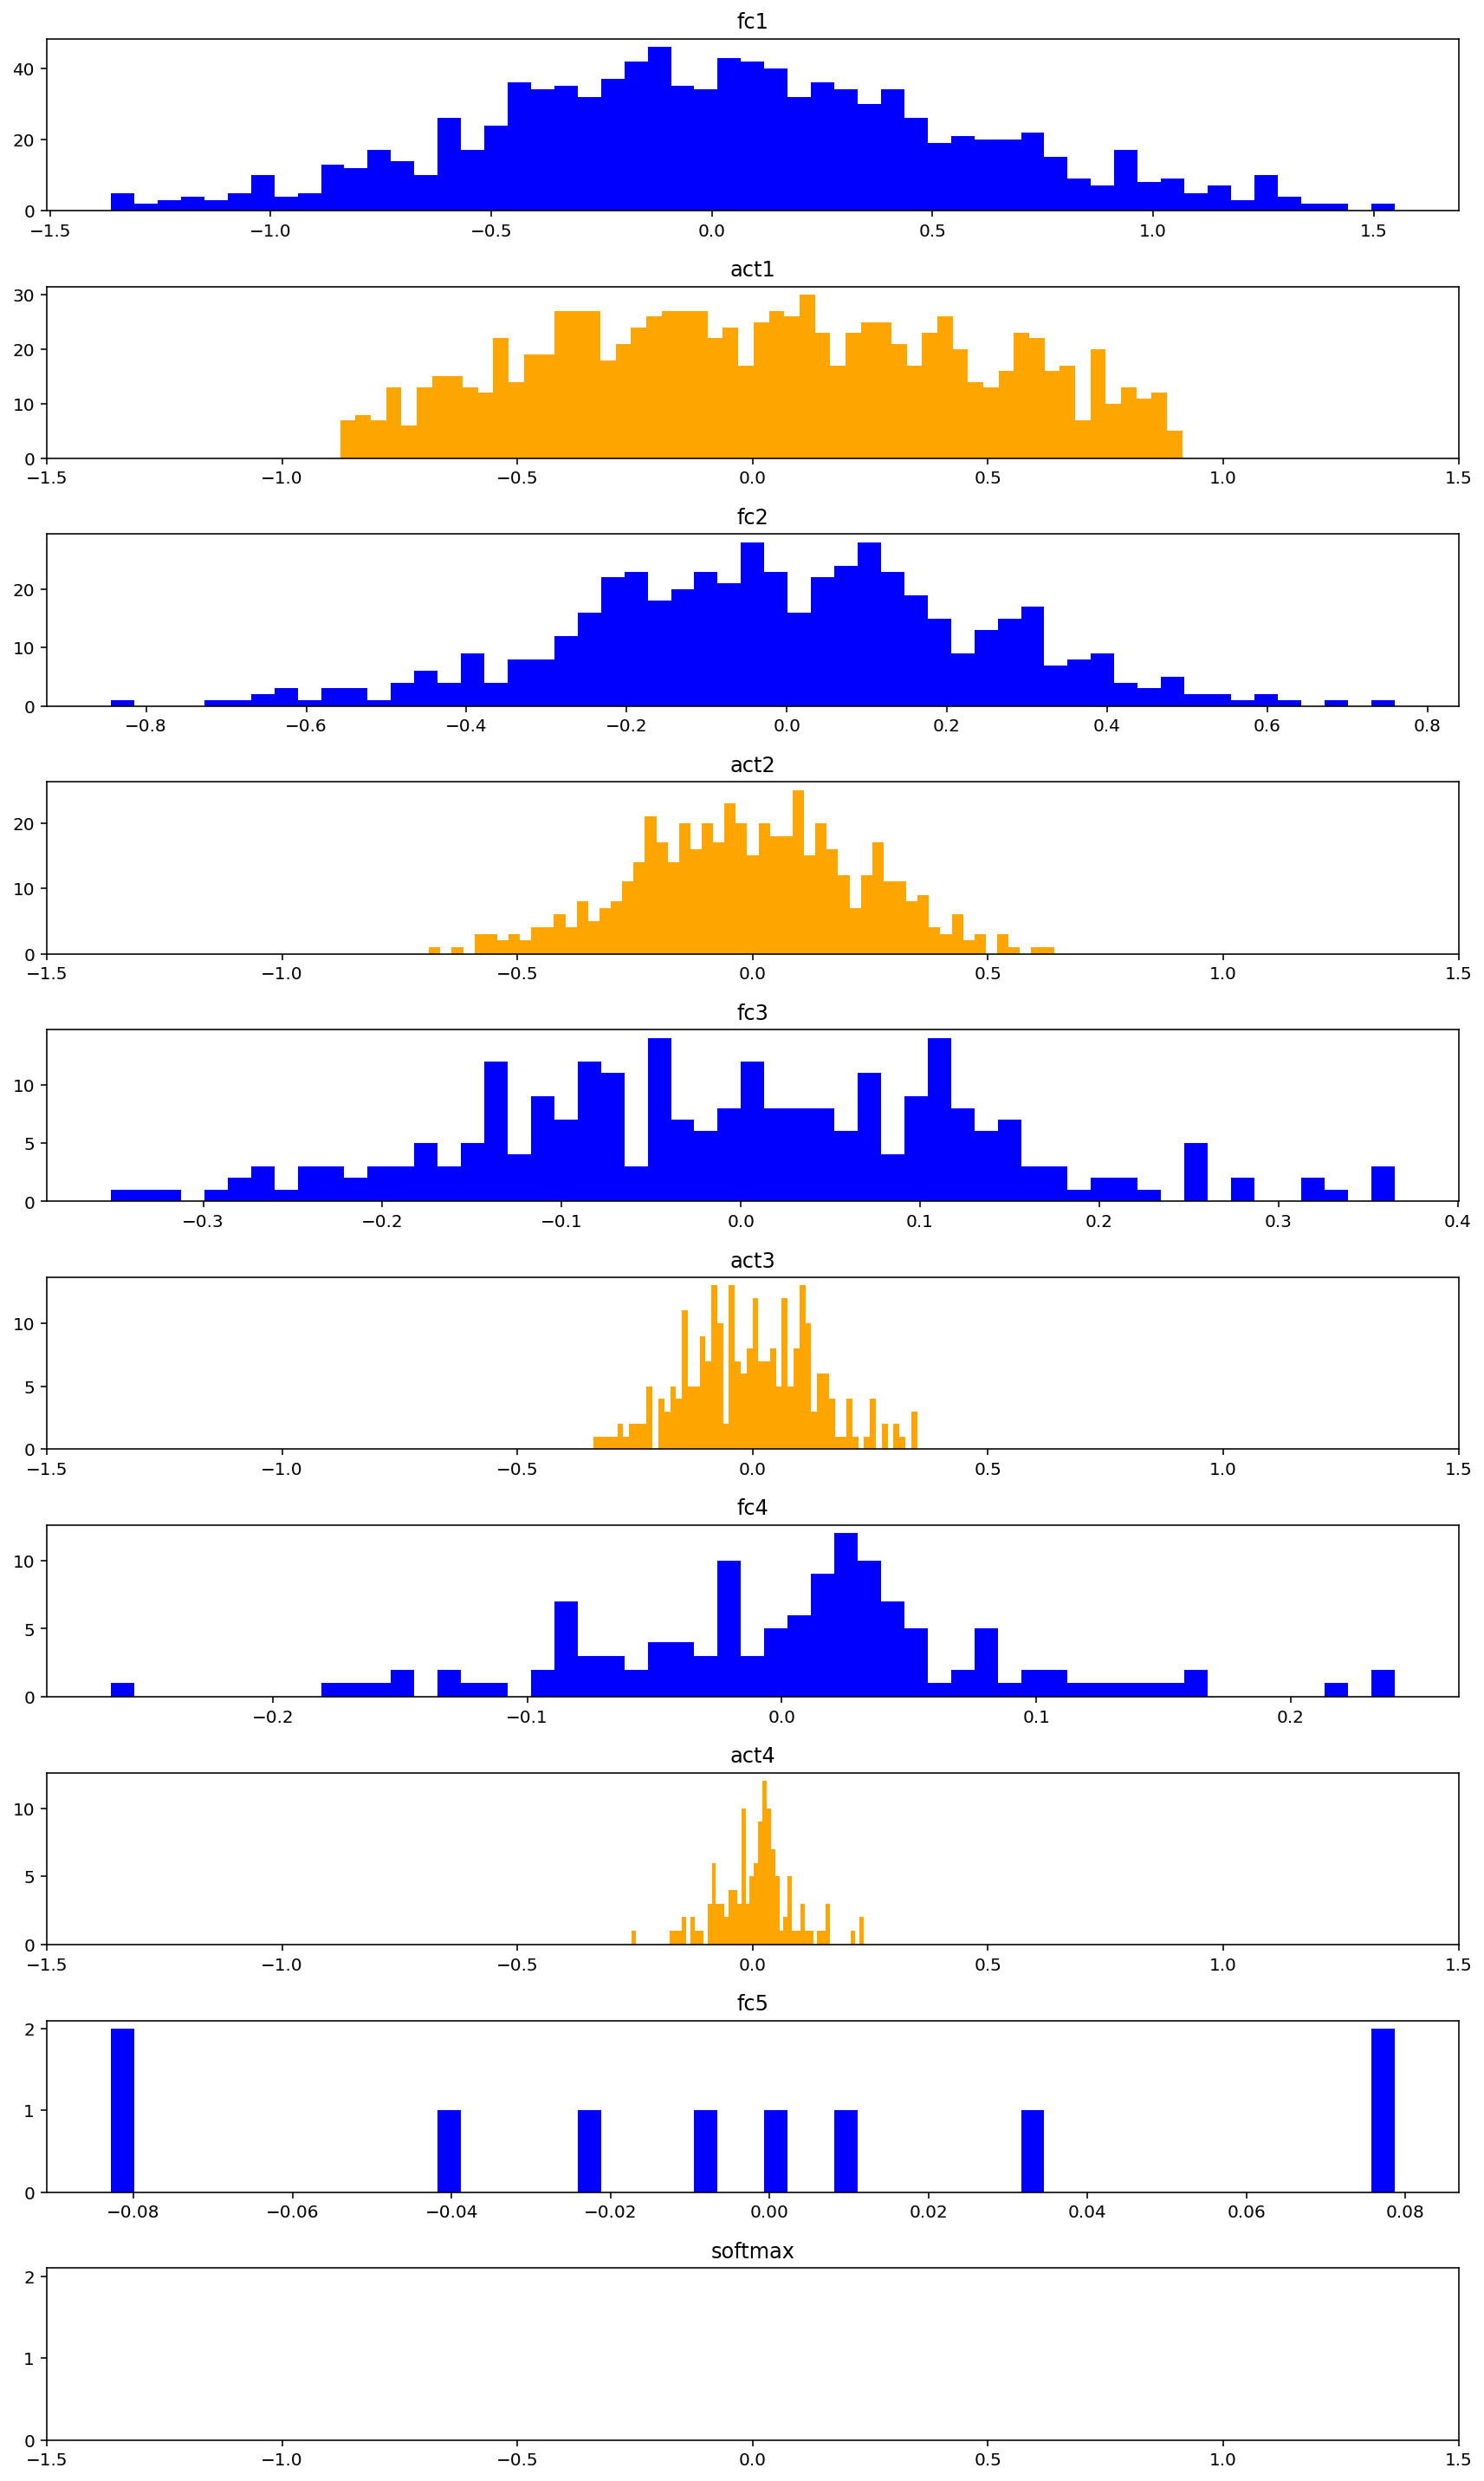

In [24]:
plot_activations(activations_uniform_rule)

In [25]:
losses_uniform_rule = training(model_uniform_rule)

Epoch 1 losses : -0.7253357992052777
Epoch 2 losses : -0.7613151192919281

Test Accuracy: 76% (7617/10000)
Valid Loss:  -0.76132485517271


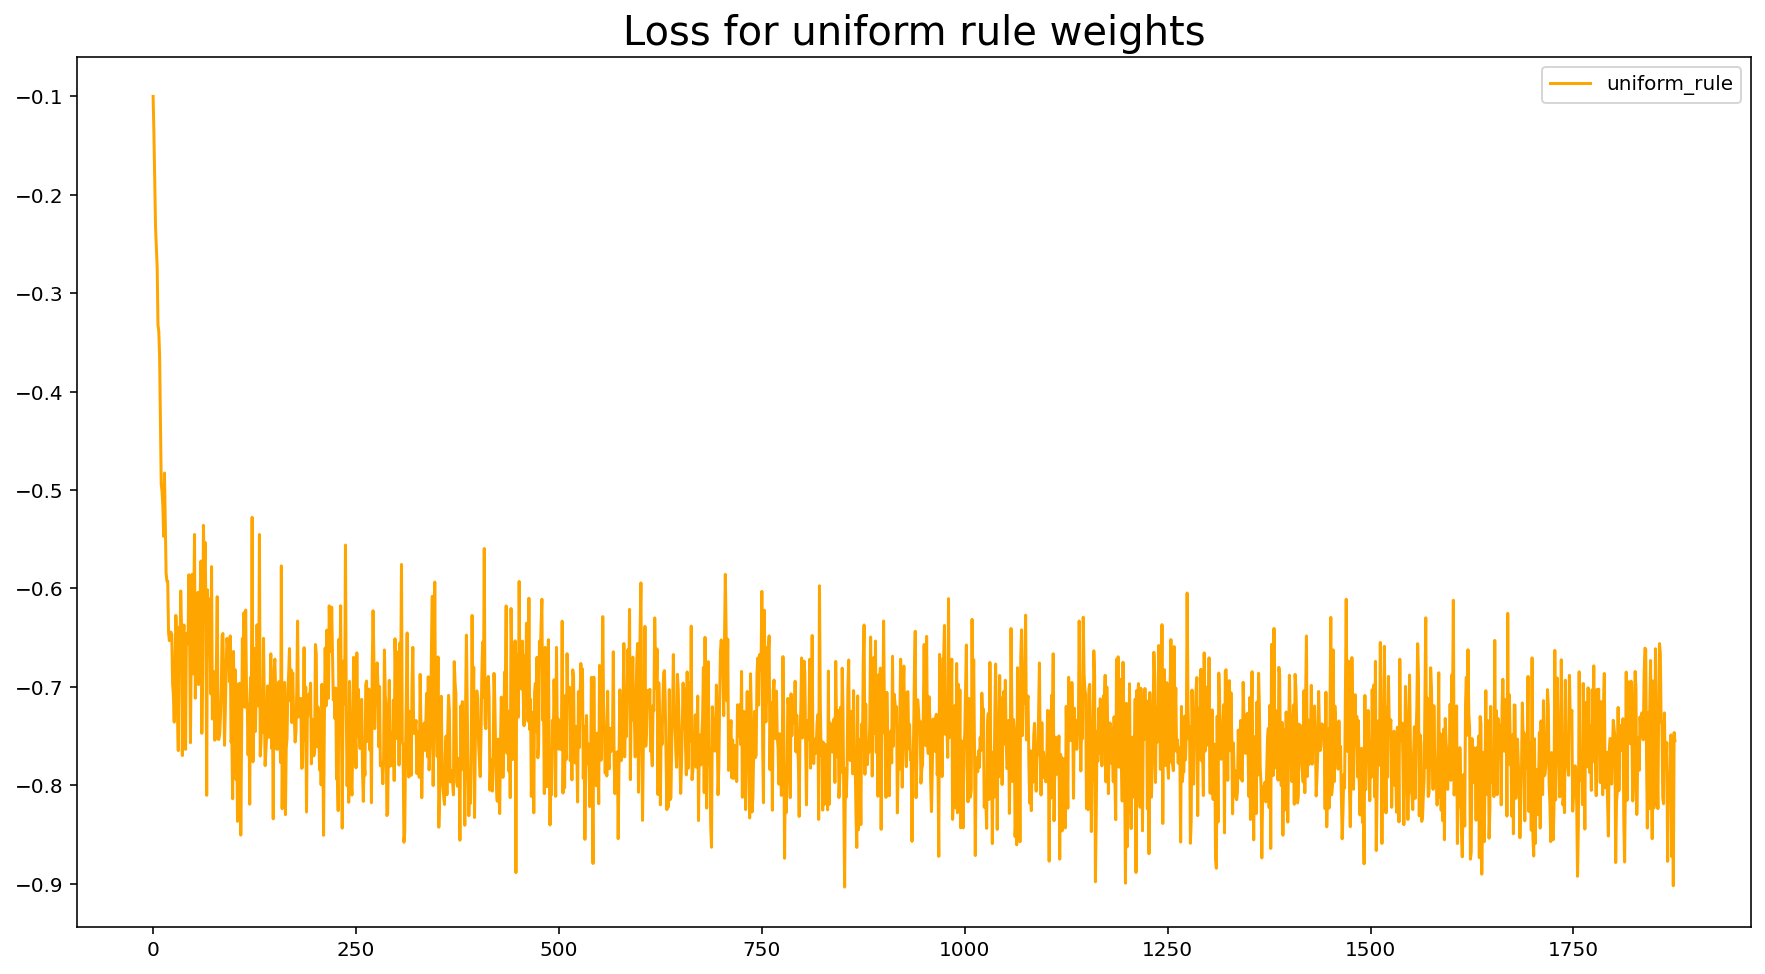

In [26]:
plt.figure(figsize=(15,8))
plt.plot(losses_uniform_rule, label='uniform_rule', color = 'orange')
_ = plt.legend()
_ = plt.title('Loss for uniform rule weights', fontsize=20)




> The general rule works quite well. We get an accuracy of 76% for same number of epochs as before. Next we try a similar approach but with values drawn from Normal distribution (mean 0, variance 1)

### 4. Set near zero normal

In [83]:
# takes in a module and applies the specified weight initialization
def weights_init_normal(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features
        y = (1.0/np.sqrt(n))
        m.weight.data.normal_(0, y)
#        m.bias.data.fill_(0)
        m.bias.data.normal_(0, y)

In [84]:
# create a new model with these weights
model_normal = Network(activation)
model_normal.apply(weights_init_normal)

Network(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (act1): Tanh()
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (act2): Tanh()
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (act3): Tanh()
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (act4): Tanh()
  (fc5): Linear(in_features=128, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

In [85]:
activations_normal = forward_hooks(model_normal)
out = model_normal(next(iter(trainloader))[0].reshape(64,-1))

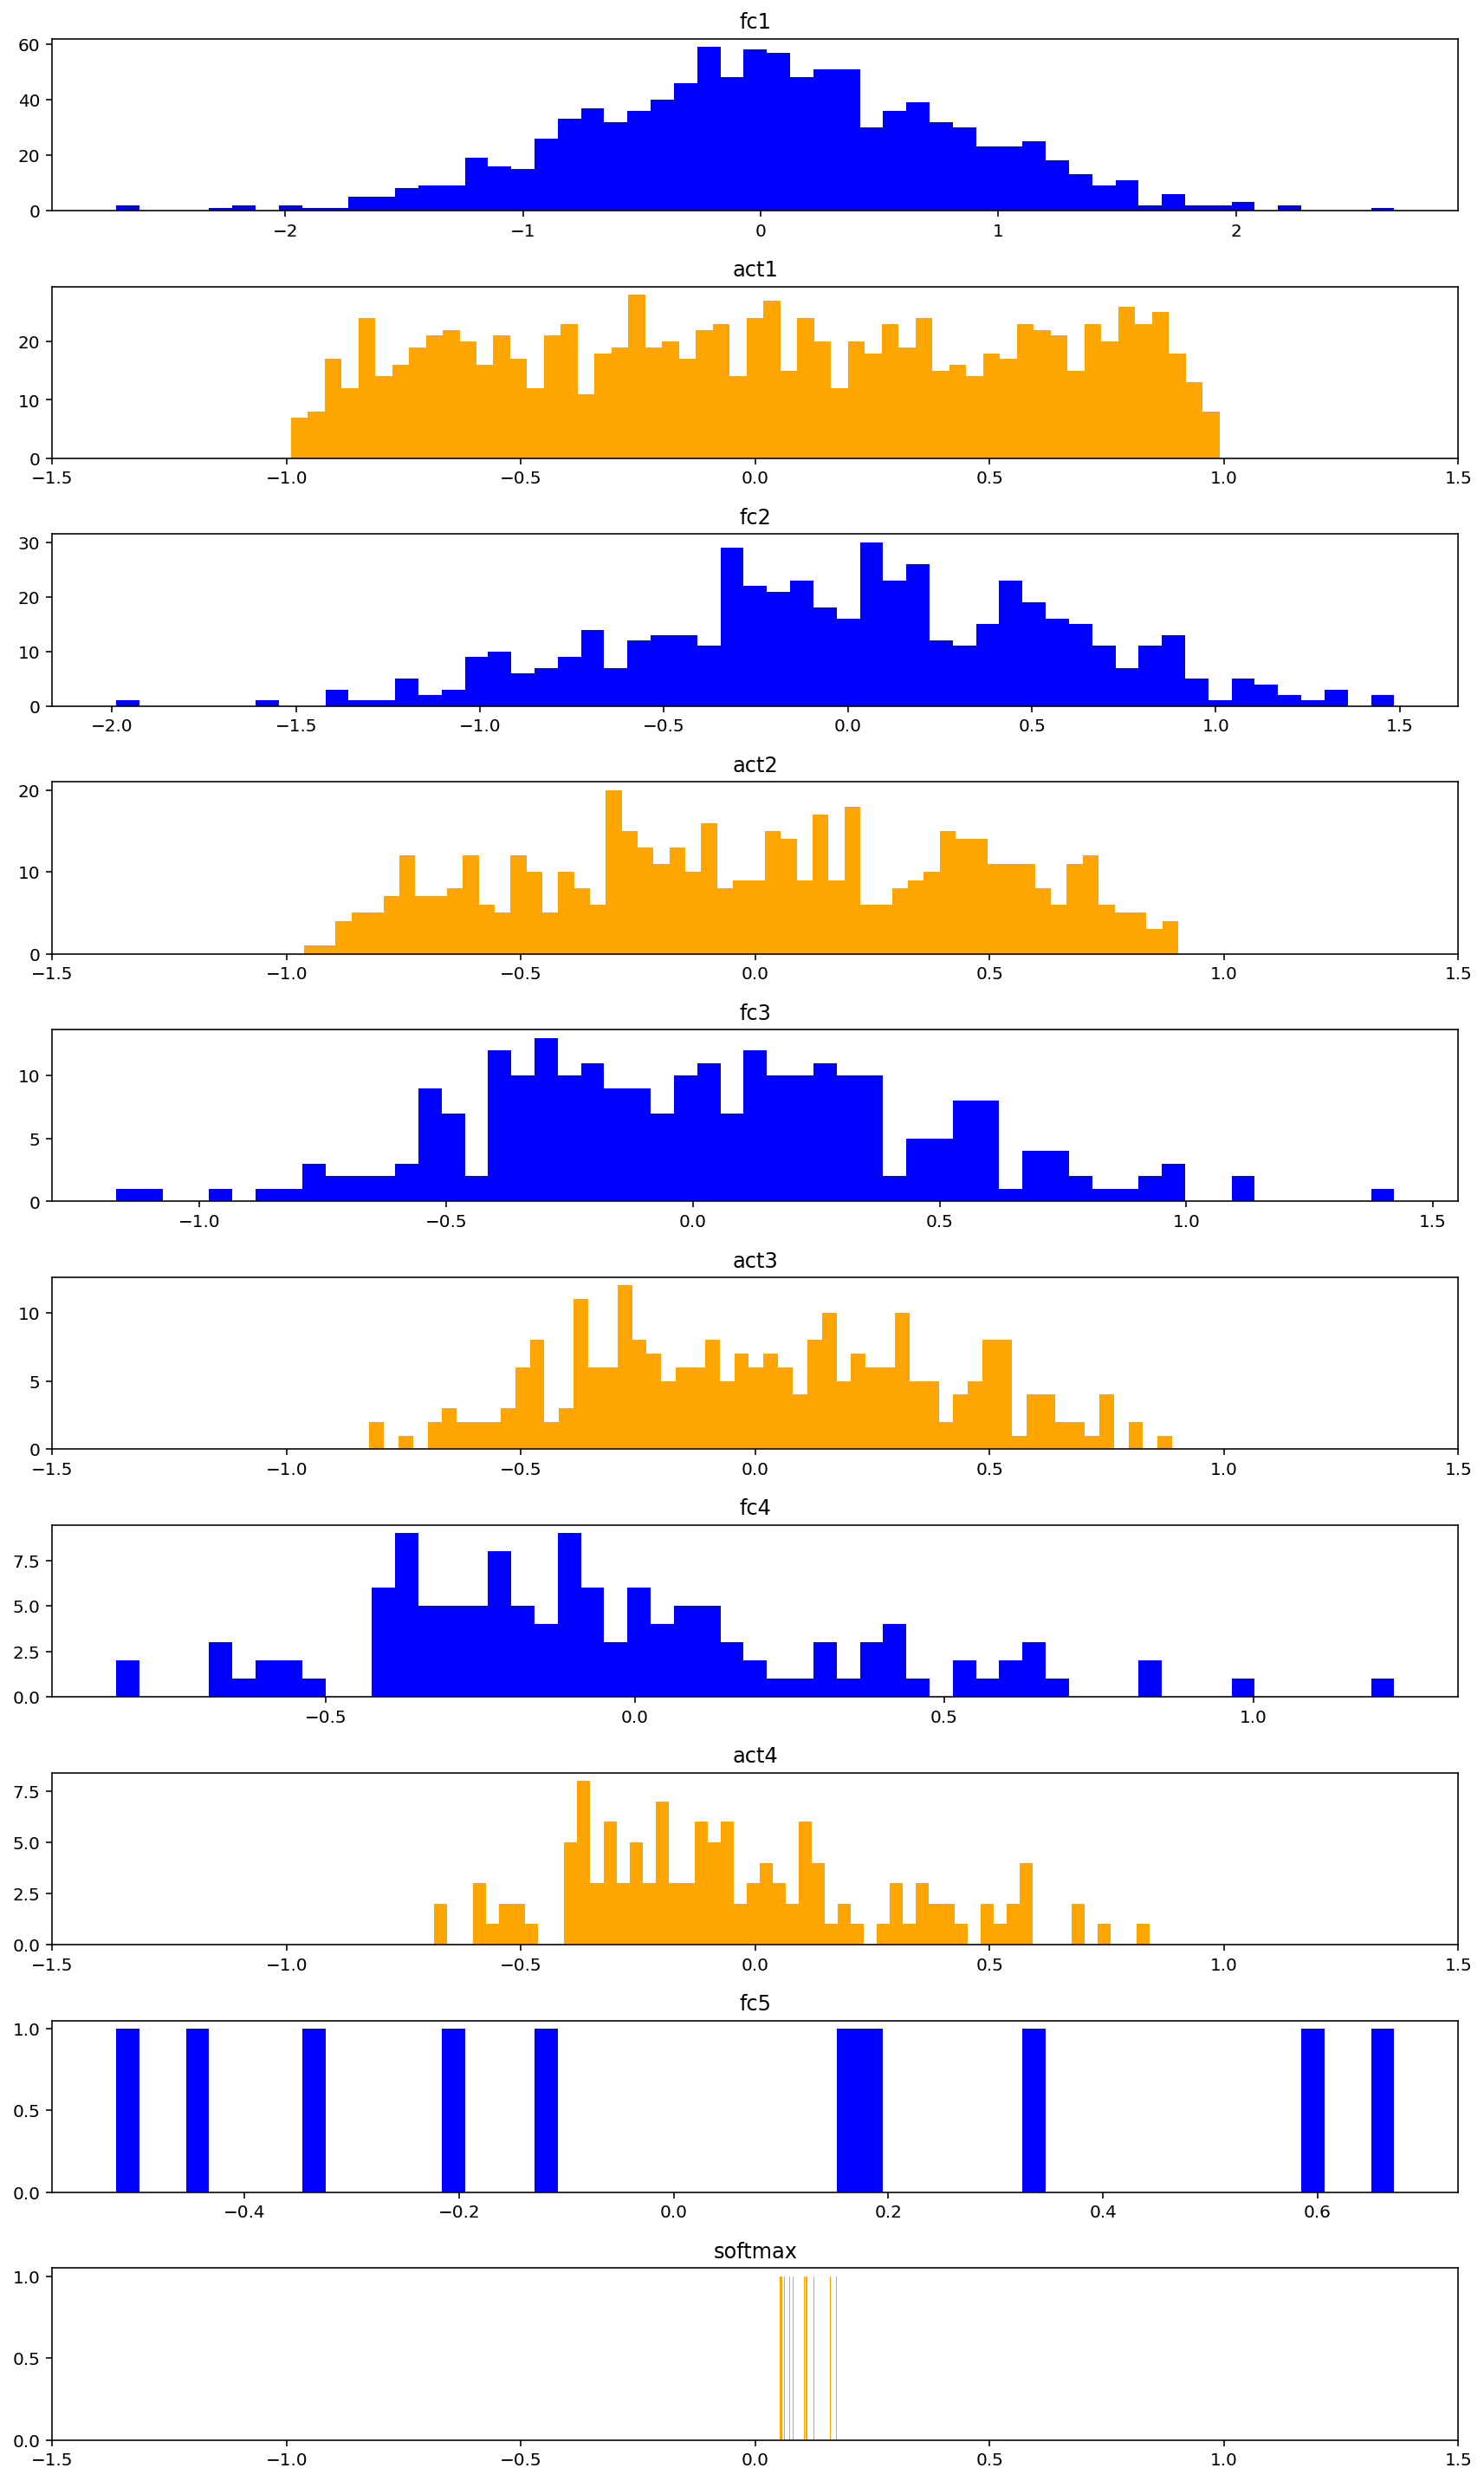

In [29]:
plot_activations(activations_normal)

In [30]:
losses_normal = training(model_normal)

Epoch 1 losses : -0.7403284438383351
Epoch 2 losses : -0.7700241863219219

Test Accuracy: 77% (7742/10000)
Valid Loss:  -0.7722939708430301


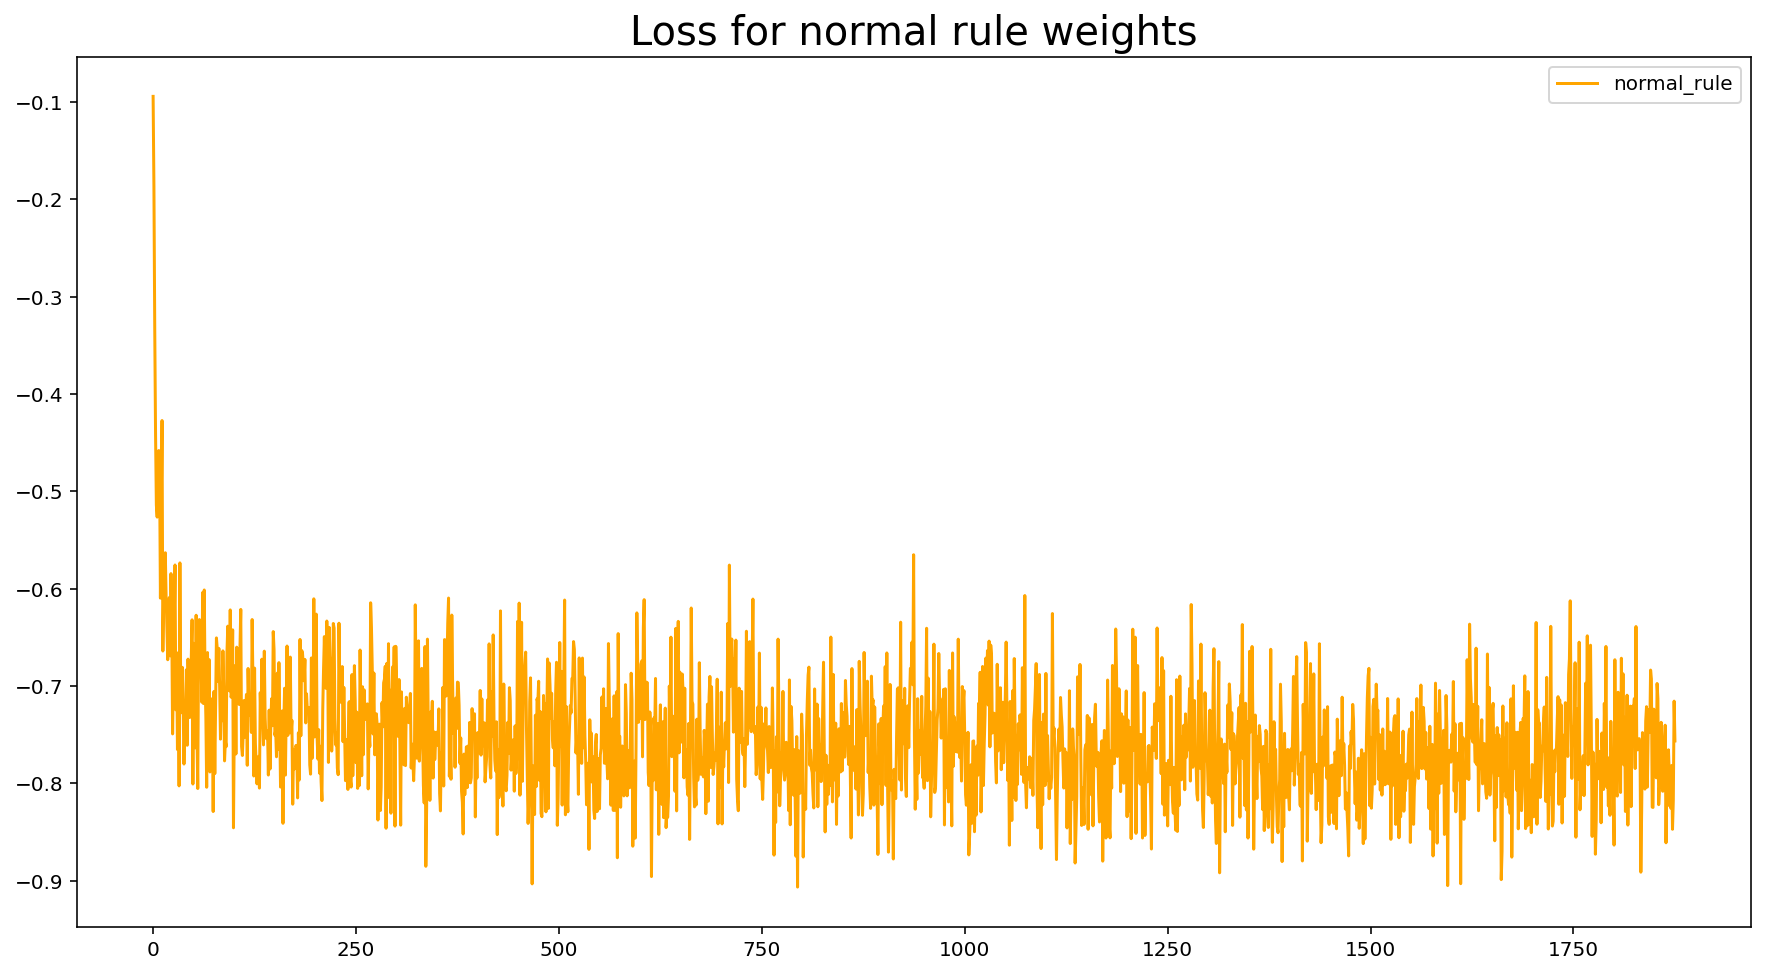

In [31]:
plt.figure(figsize=(15,8))
plt.plot(losses_normal, label='normal_rule', color = 'orange')
_ = plt.legend()
_ = plt.title('Loss for normal rule weights', fontsize=20)

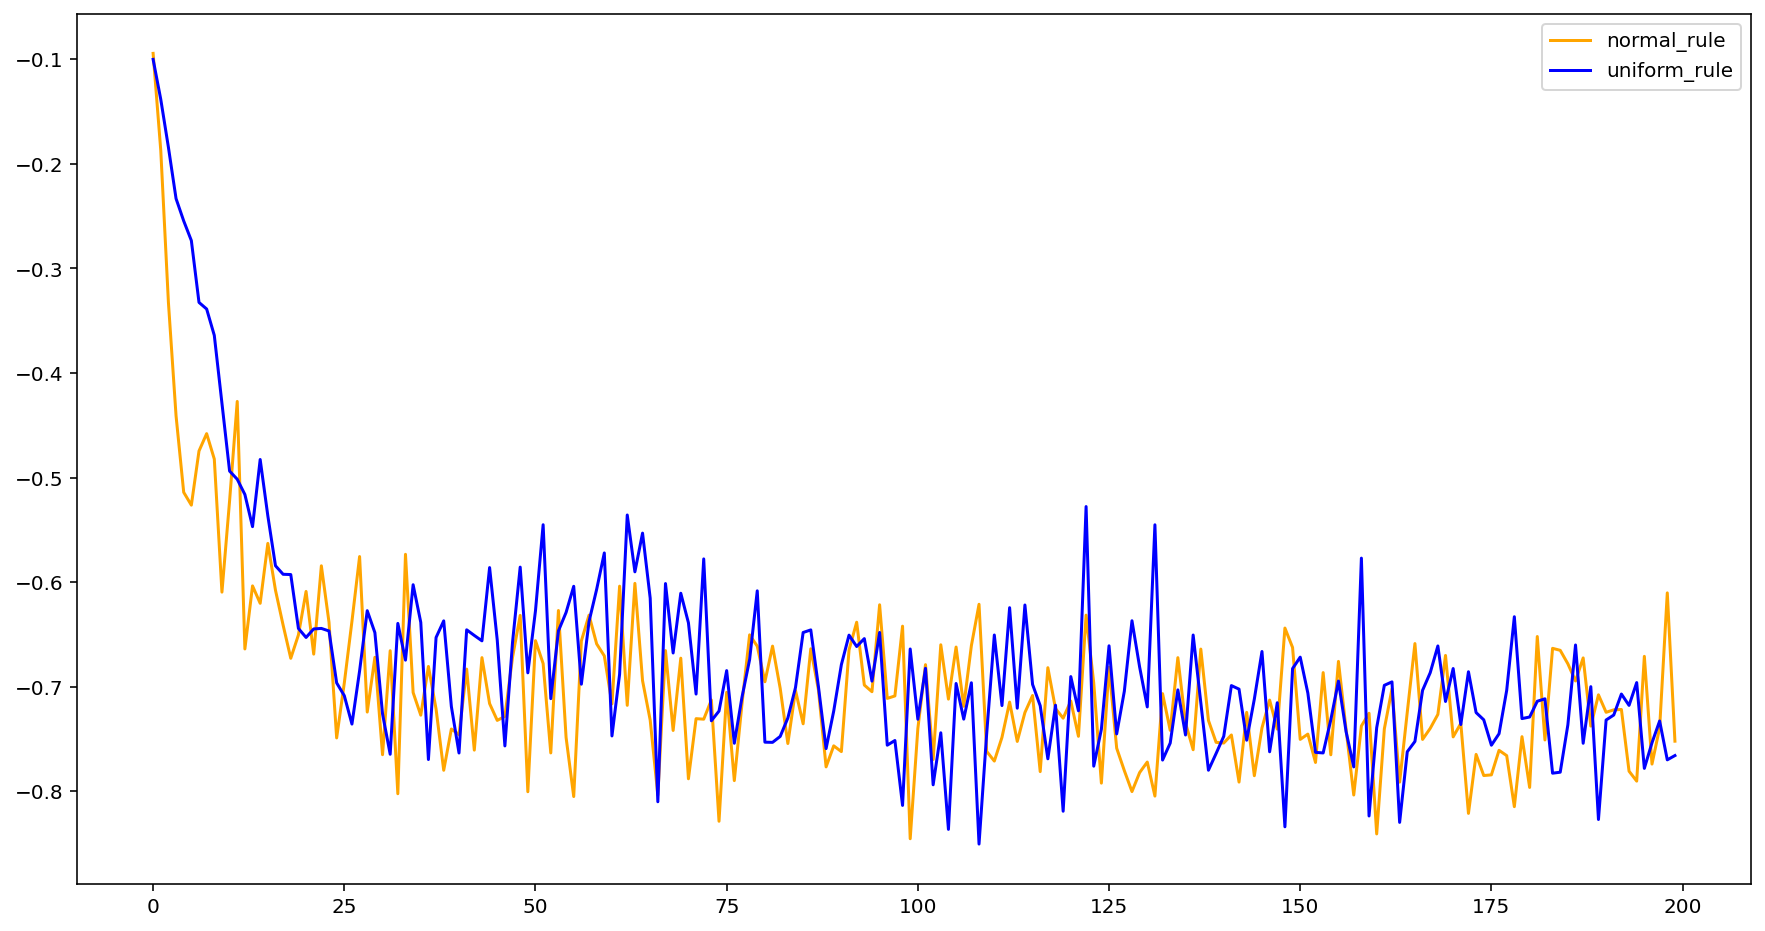

In [32]:
plt.figure(figsize=(15,8))
plt.plot(losses_normal[:200], label='normal_rule', color = 'orange')
plt.plot(losses_uniform_rule[:200], label='uniform_rule', color = 'blue')
_ = plt.legend()

> We can see the weights drawn from normal distribution works better initially but reaches similar looses in some epochs.
A good discussion: https://datascience.stackexchange.com/questions/13061/when-to-use-he-or-glorot-normal-initialization-over-uniform-init-and-what-are/13362#13362

### 5. Defualt initialization
I wanted to compare the above two approaches with the default init of pytorch

In [33]:
model_default = Network(activation)

In [34]:
activations_defualt = forward_hooks(model_default)
out = model_default(next(iter(trainloader))[0].reshape(64,-1))

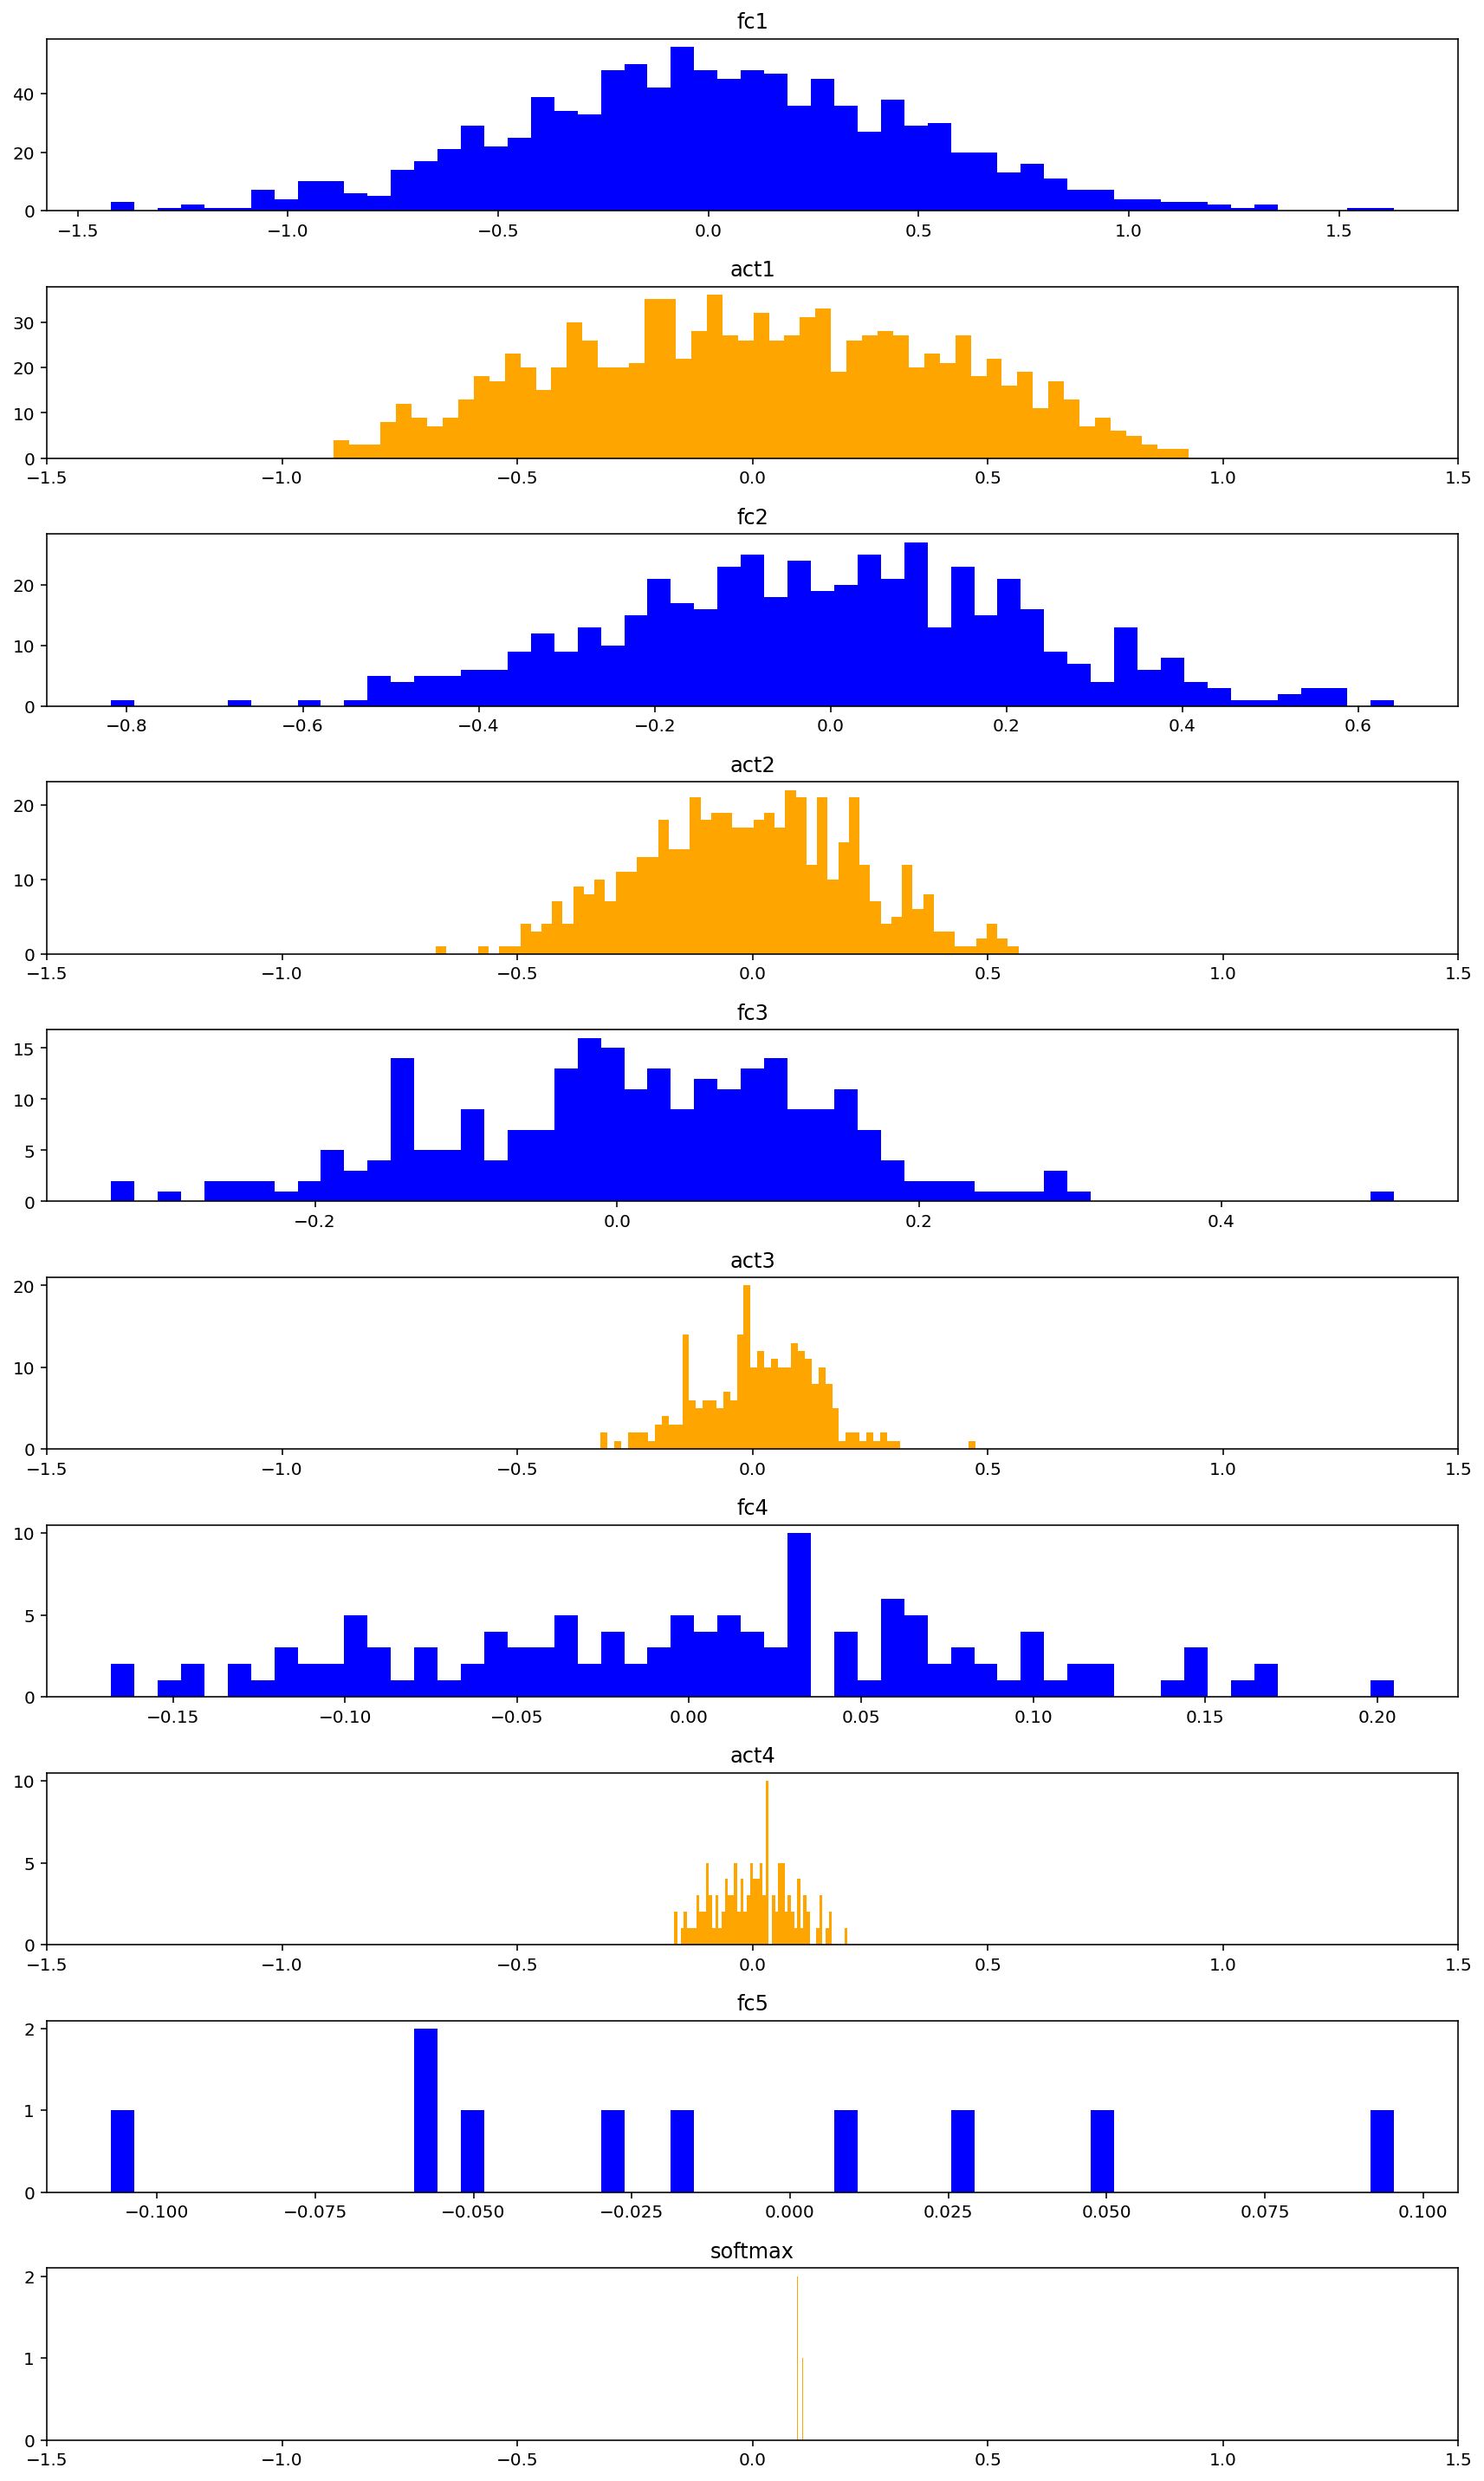

In [35]:
plot_activations(activations_defualt)

In [36]:
losses_default = training(model_normal)

Epoch 1 losses : -0.7781283976172583
Epoch 2 losses : -0.787646328843733

Test Accuracy: 76% (7623/10000)
Valid Loss:  -0.7598324467422094


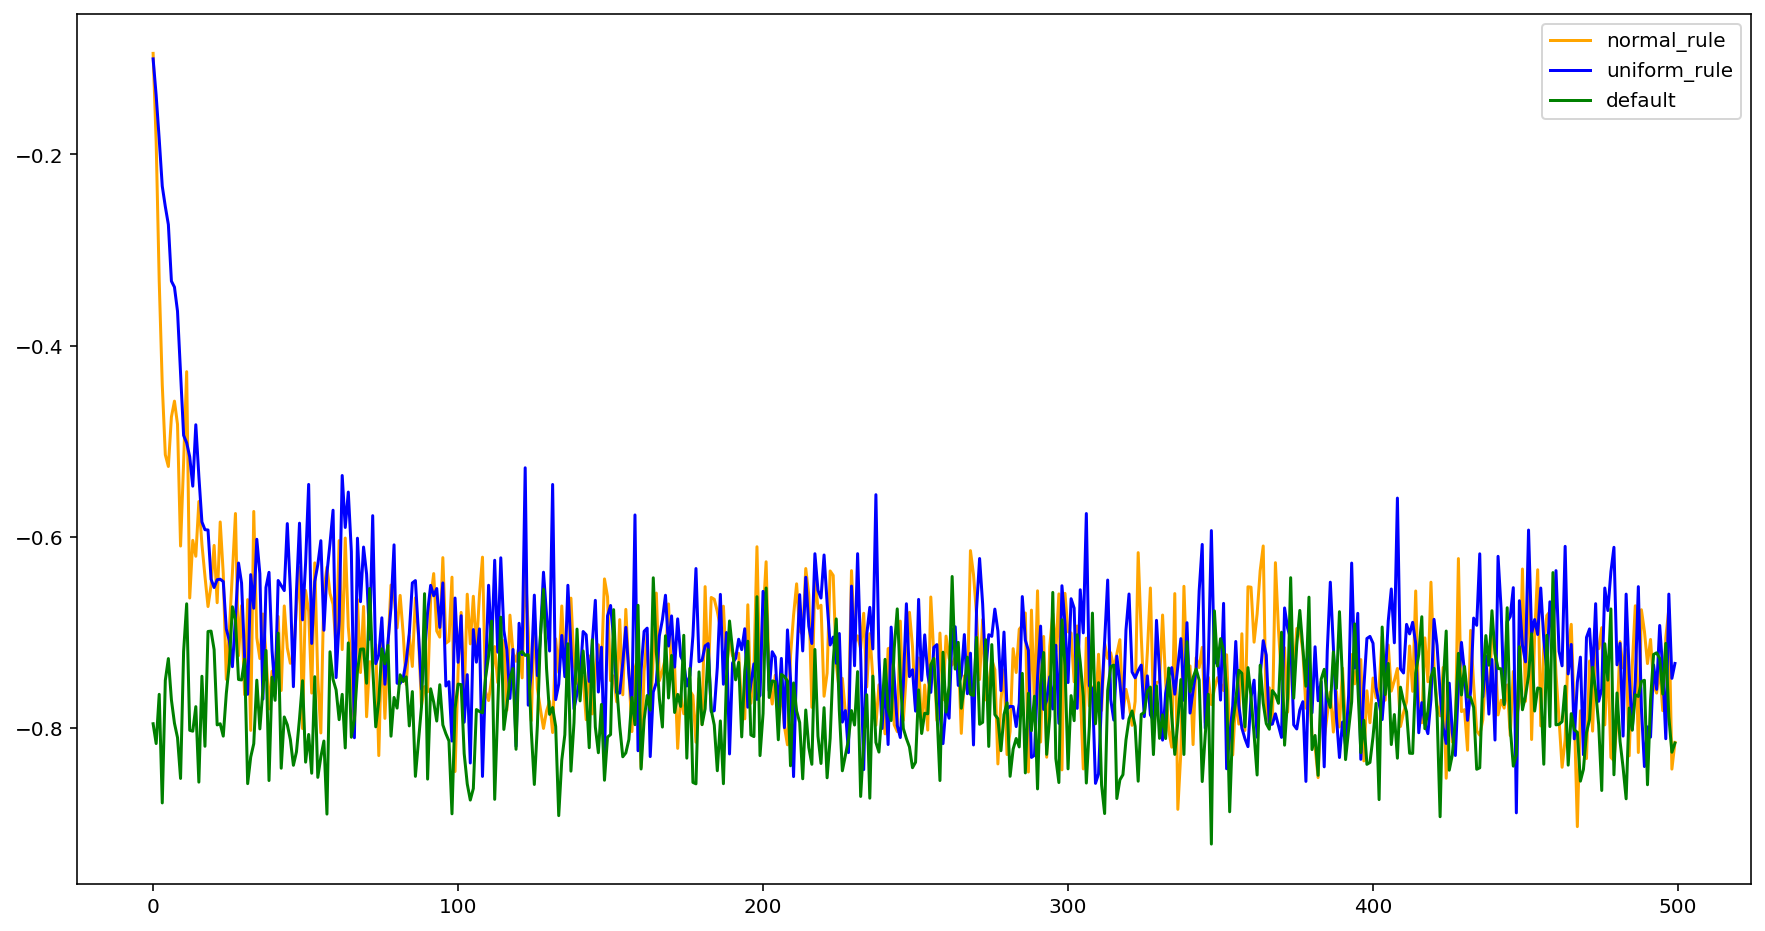

In [37]:
plt.figure(figsize=(15,8))
plt.plot(losses_normal[:500], label='normal_rule', color = 'orange')
plt.plot(losses_uniform_rule[:500], label='uniform_rule', color = 'blue')
plt.plot(losses_default[:500], label='default', color = 'green')
_ = plt.legend()

> It gives a very similar performance on our dataset. The only difference I could see was the initial drop in loss. Pytorch Linear layer uses the uniform general rule formula to init the weights.